# Technical Note #1 March 2024 - SnowC2

In [76]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

In [85]:
# https://www.w3schools.com/python/python_classes.asp

class Site:
  def __init__(self, name, long_name, location, lat, lon, elevation, period, start, stop, period_used, run):
    self.name = name
    self.long_name = long_name
    self.location = location
    self.lat = lat
    self.lon = lon
    self.elevation = elevation
    self.period = period
    self.start = start
    self.stop = stop
    self.period_used = period_used
    self.run = run

exps = ['Ref_30min_ext', 'EZERO_30min_ext']

# SnowMIP
cdp = Site('cdp', 'Col de Porte, France', '45.30°N, 5.77°E', 45.30, 5.77, '1325 m', 
           '1 October 1994 to 30 September 2014', '1994-10-01', '2014-09-30', slice('1994-10-01', '2014-09-30'), exps)

rme = Site('rme', 'Reynolds Mountain East, Idaho, USA', '43.19°N, 116.78°W', 43.19, -116.78, '2060 m', 
           '1 October 1988 to 30 September 2008', '1988-10-01', '2008-09-30', slice('1988-10-01', '2008-09-30'), exps)

snb = Site('snb', 'Senator Beck, Colorado, US', '37.91°N, 107.73°W', 37.91, -107.73, '3714 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

swa = Site('swa', 'Swamp Angel, Colorado, USA', '37.91°N, 107.71°W', 37.91, -107.71, '3371 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sap = Site('sap', 'Sapporo, Japan', '43.08°N, 141.34°E', 43.08, 141.34, '15 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sod = Site('sod', 'Sodankylä, Finland', '67.37°N, 26.63°E', 67.37, 26.63, '179 m', 
           '1 October 2007 to 30 September 2014', '2007-10-01', '2014-09-30', slice('2007-10-01', '2014-09-30'), exps)

wfj = Site('wfj', 'Weissfluhjoch, Switzerland', '46.83°N, 9.81°E', 46.83, 9.81, '2540 m', 
           '1 September 1996 to 31 August 2016', '1996-10-01', '2016-08-31', slice('1996-10-01', '2016-08-31'), exps)

# Arctic 
byl = Site('byl', 'Bylot Island, Canadian high Arctic', '73.15°N, 80.00°W', 73.15, -80.00, '25 m', 
           '11 July 2013 to 25 June 2019', '2013-07-11', '2019-06-25', slice('2014-07-11', '2019-06-25'), 
           ['peat_30min_ext', 'peat_EZERO_30min_ext'])

umt = Site('umt', 'Umiujaq TUNDRA, northeastern Canada', '56.55877°N, 76.48234°W', 56.55877, -76.48234, '132 m', 
           '28 Sept 2012 to 15 October 2021', '2012-09-28', '2021-10-15', slice('2016-09-01', '2021-08-31'), 
           ['Ref', 'EZERO'])

umf = Site('umf', 'Umiujaq FOREST, northeastern Canada', '56.55308°N, 76.47258°W', 56.55308, -76.47258, '82 m', 
           '26 Nov 2015 to 19 October 2021', '2015-11-26', '2021-10-19', slice('2018-09-01', '2021-08-31'), 
           ['Ref', 'EZERO'])


In [78]:
SnowMIP_sites = [cdp, rme, snb, swa, sap, sod, wfj]
SnowArctic_sites = [byl, umt, umf]

path_SnowMIP = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'
path_SnowArctic = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'
path_Paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'

ds_d_SnowMIP_list = []
for i, exp in enumerate(exps):
    paths_SnowMIP = [path_SnowMIP+site.name+'/'+'run_'+exp for site in SnowMIP_sites]
    # Change the syntax as the ref run is not necessarily having the same name for all sites
    paths_SnowArctic = [path_SnowArctic+site.name+'/'+'run_'+site.run[i] for site in SnowArctic_sites]
    paths = paths_SnowMIP + paths_SnowArctic
    ds_d_SnowMIP_list.append([xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths])


ds_d_Paul_list = []
for site in SnowMIP_sites:
    df_Paul = pd.read_csv(path_Paul+'/CLASS_sv_REF_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.txt', delim_whitespace=True)
    df_Paul.index = pd.to_datetime(df_Paul[['year', 'month', 'day', 'hour']]).values
    df_Paul= df_Paul.drop(columns=['year', 'month', 'day', 'hour'])
    df_Paul.albsn = df_Paul.albsn.replace({0 : np.nan})
    df_Paul.albs = df_Paul.albs.replace({0 : np.nan})
    df_Paul.tsn = df_Paul.tsn.replace({-999 : np.nan})
    df_Paul.tsns = df_Paul.tsns.replace({-999 : np.nan})
    ds_Paul_h = df_Paul.to_xarray()
    ds_Paul_h = ds_Paul_h.rename({'index': 'time'})
    ds_Paul_d = ds_Paul_h.resample(time='D').mean().load()
    ds_Paul_d = ds_Paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])
    

    # Combine the Soil temperature in one variable
    ds_Paul_d = ds_Paul_d.assign(
        tsl=(('layer', 'time'), [
            list(ds_Paul_d['tsl:1'].values),
            list(ds_Paul_d['tsl:2'].values),
            list(ds_Paul_d['tsl:3'].values),
        ])
    )
        
    ds_d_Paul_list.append(ds_Paul_d)

## Set soil levels

In [79]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp"
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [80]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [81]:
for i, exp in enumerate(exps):
    for j in range(len(SnowMIP_sites+SnowArctic_sites)):
        ds_d_SnowMIP_list[i][j] = assign_center_depth(ds_d_SnowMIP_list[i][j], rsfile)

## Compare with obs

In [82]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_d_Obs_list = []
for site in SnowMIP_sites:
    ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc')
    ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_eval_menard2019)

In [83]:
path_obs_byl = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_obs_umt = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
path_obs_umf = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'

path_obs_list = [path_obs_byl, path_obs_umt, path_obs_umf]
for site, path in zip(SnowArctic_sites, path_obs_list):
    ds_h_obs = xr.open_dataset(path+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc').load()
    if site.name == 'byl':
        ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
    if site.name == 'umt':
        ds_h_obs = ds_h_obs.mean(dim='veg') # average over lichen and lowshrub area (tsl)
    ds_d_obs = ds_h_obs.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_obs)

## Merge Arctic and SnowMIP

In [790]:
# ds_d_Obs_list = ds_d_Obs_list + ds_d_Obs_Arctic_list
# ds_d_SnowMIP_list = ds_d_SnowMIP_list + ds_d_SnowArctic_list

### SD

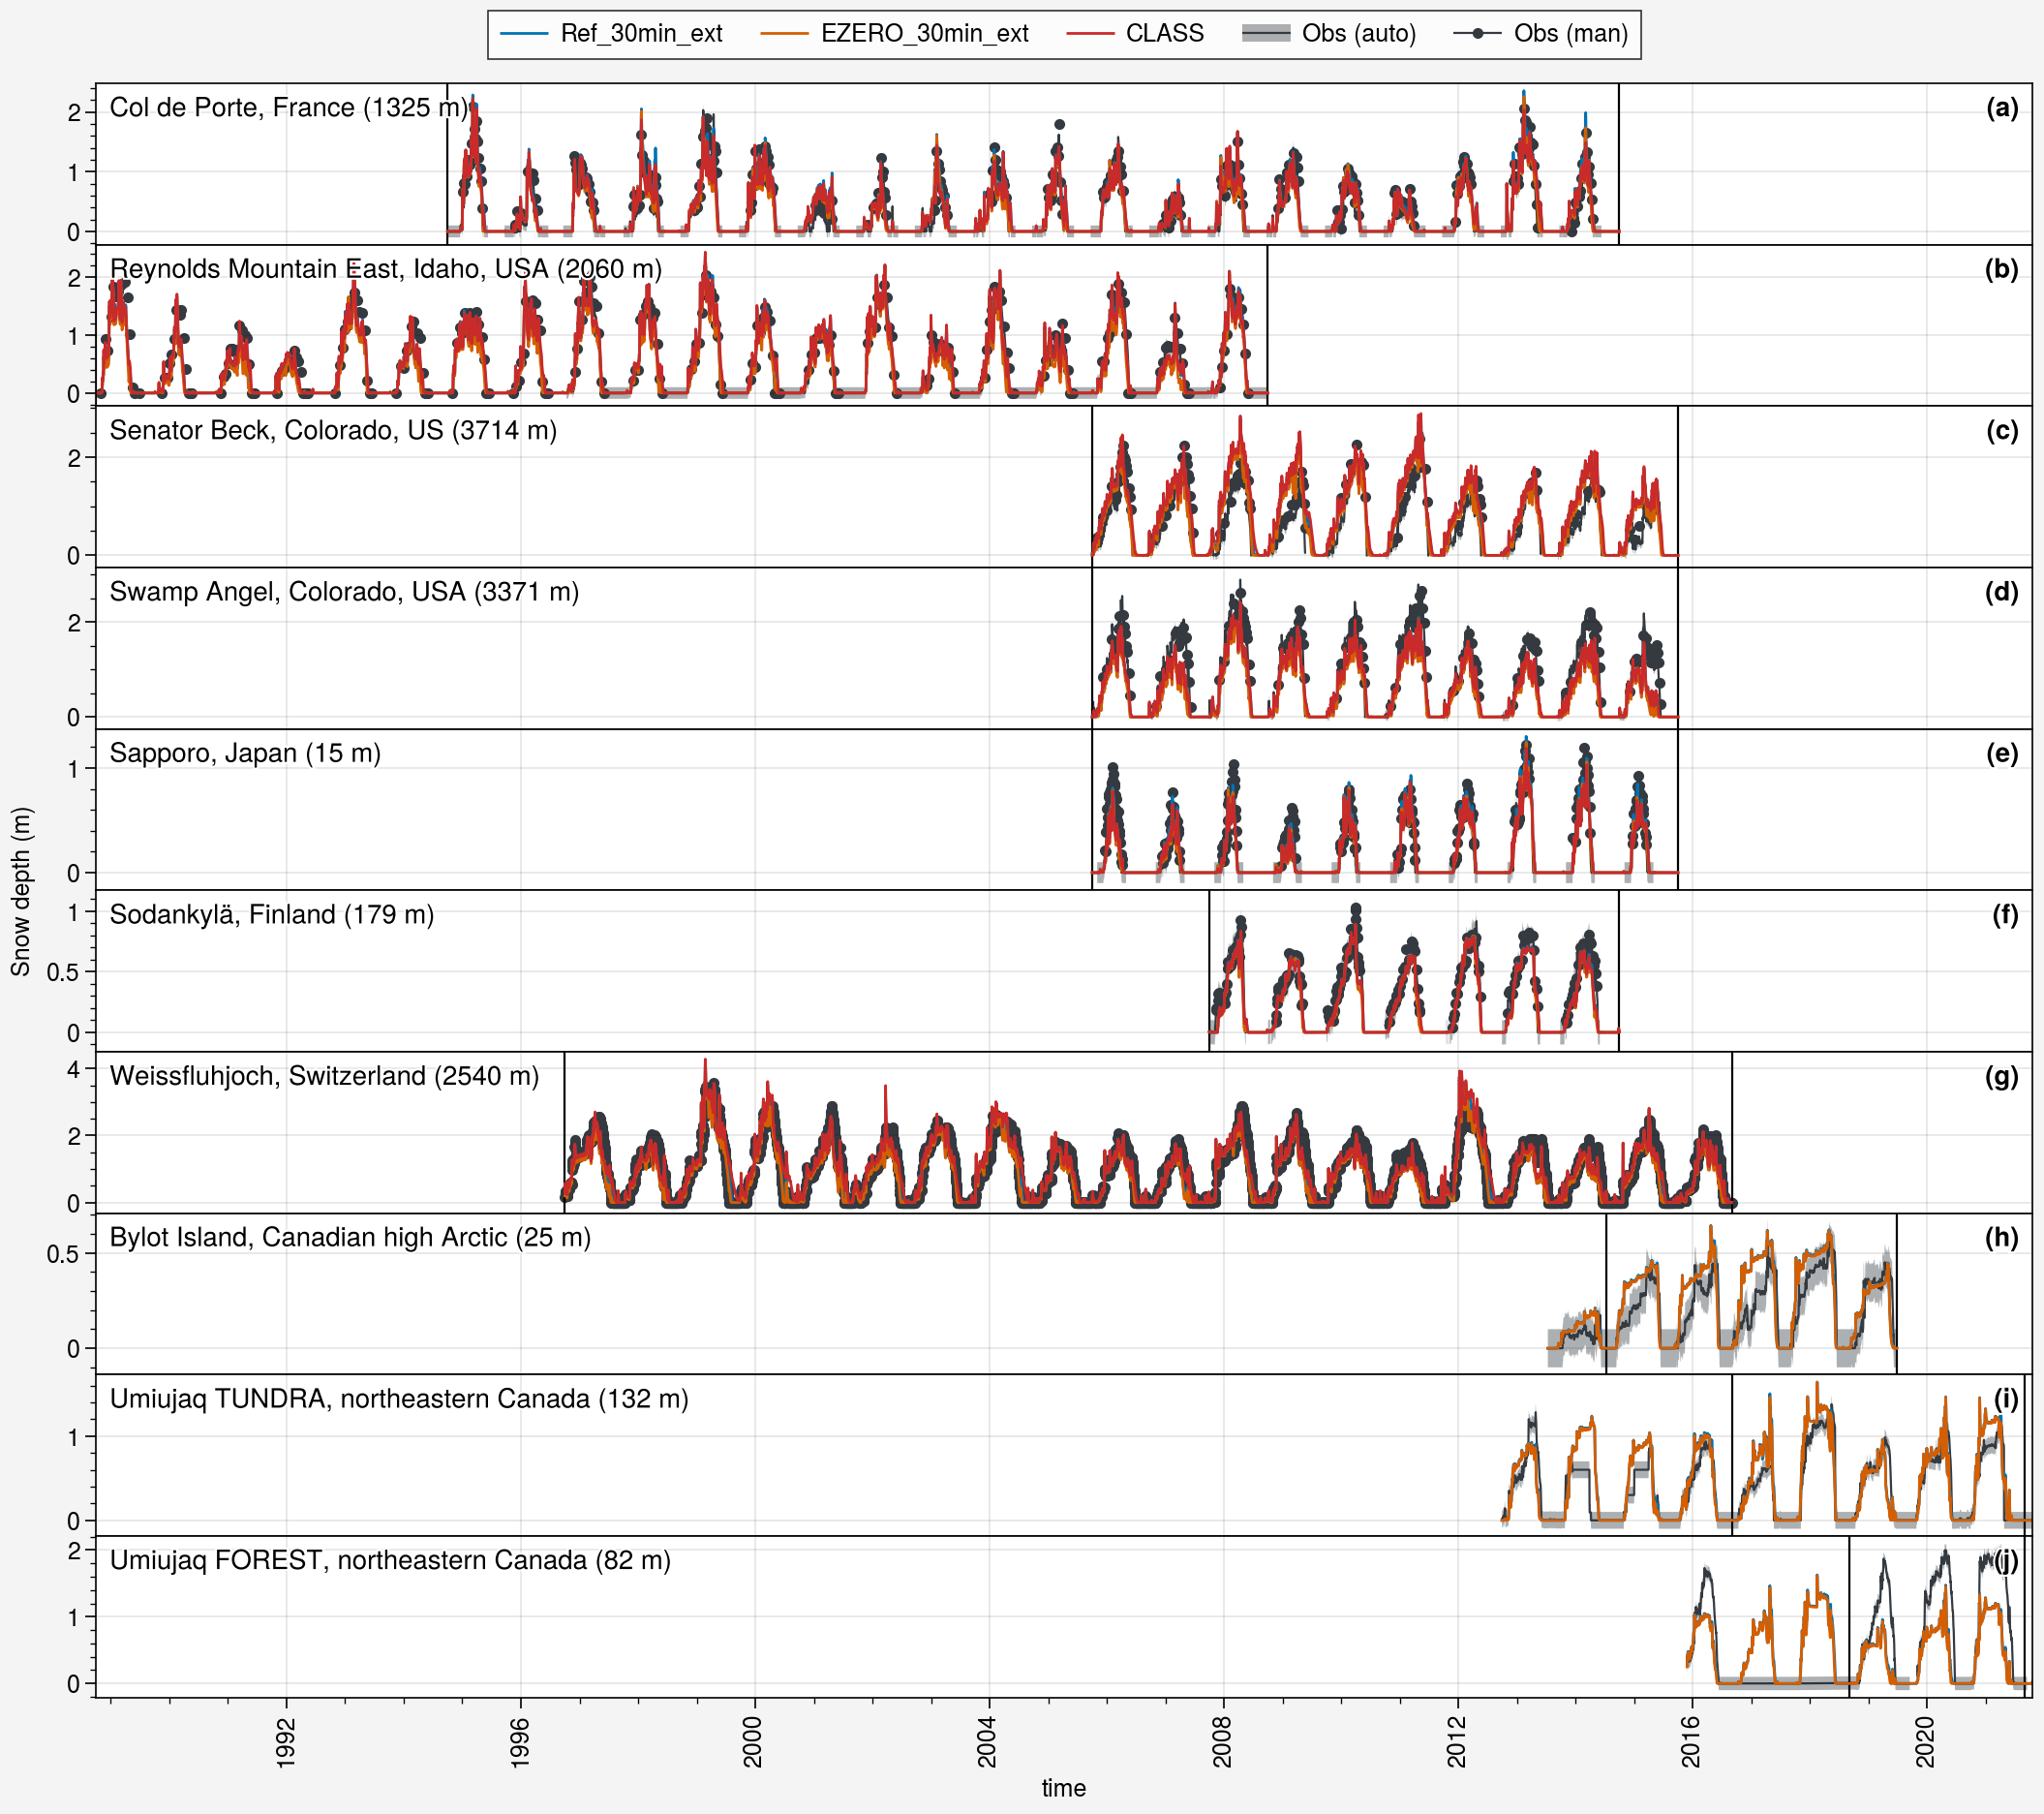

In [94]:
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=10, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    for j, exp in enumerate(exps): 
        h = axs[i].plot(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
        h_exps.append(h)

    if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values+0.1, axis=0),
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values-0.1, axis=0),), axis=0)
    h_obs_auto = axs[i].plot(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)), shadedata=shadedata, color=color_obs, 
                zorder=0, lw=0.8, label='Obs (auto)')
    
    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
        h_obs_man = axs[i].plot(ds_d_Obs_list[i].snd_man.sel(time=slice(site.start, site.stop)), marker='.', color=color_obs, 
                    zorder=0, lw=0.8, label='Obs (man)')
    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=5, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.suptitle('Col de Porte, France, 1325 m')
fig.save('img/tn1_sd.jpg')

### Annual cycles

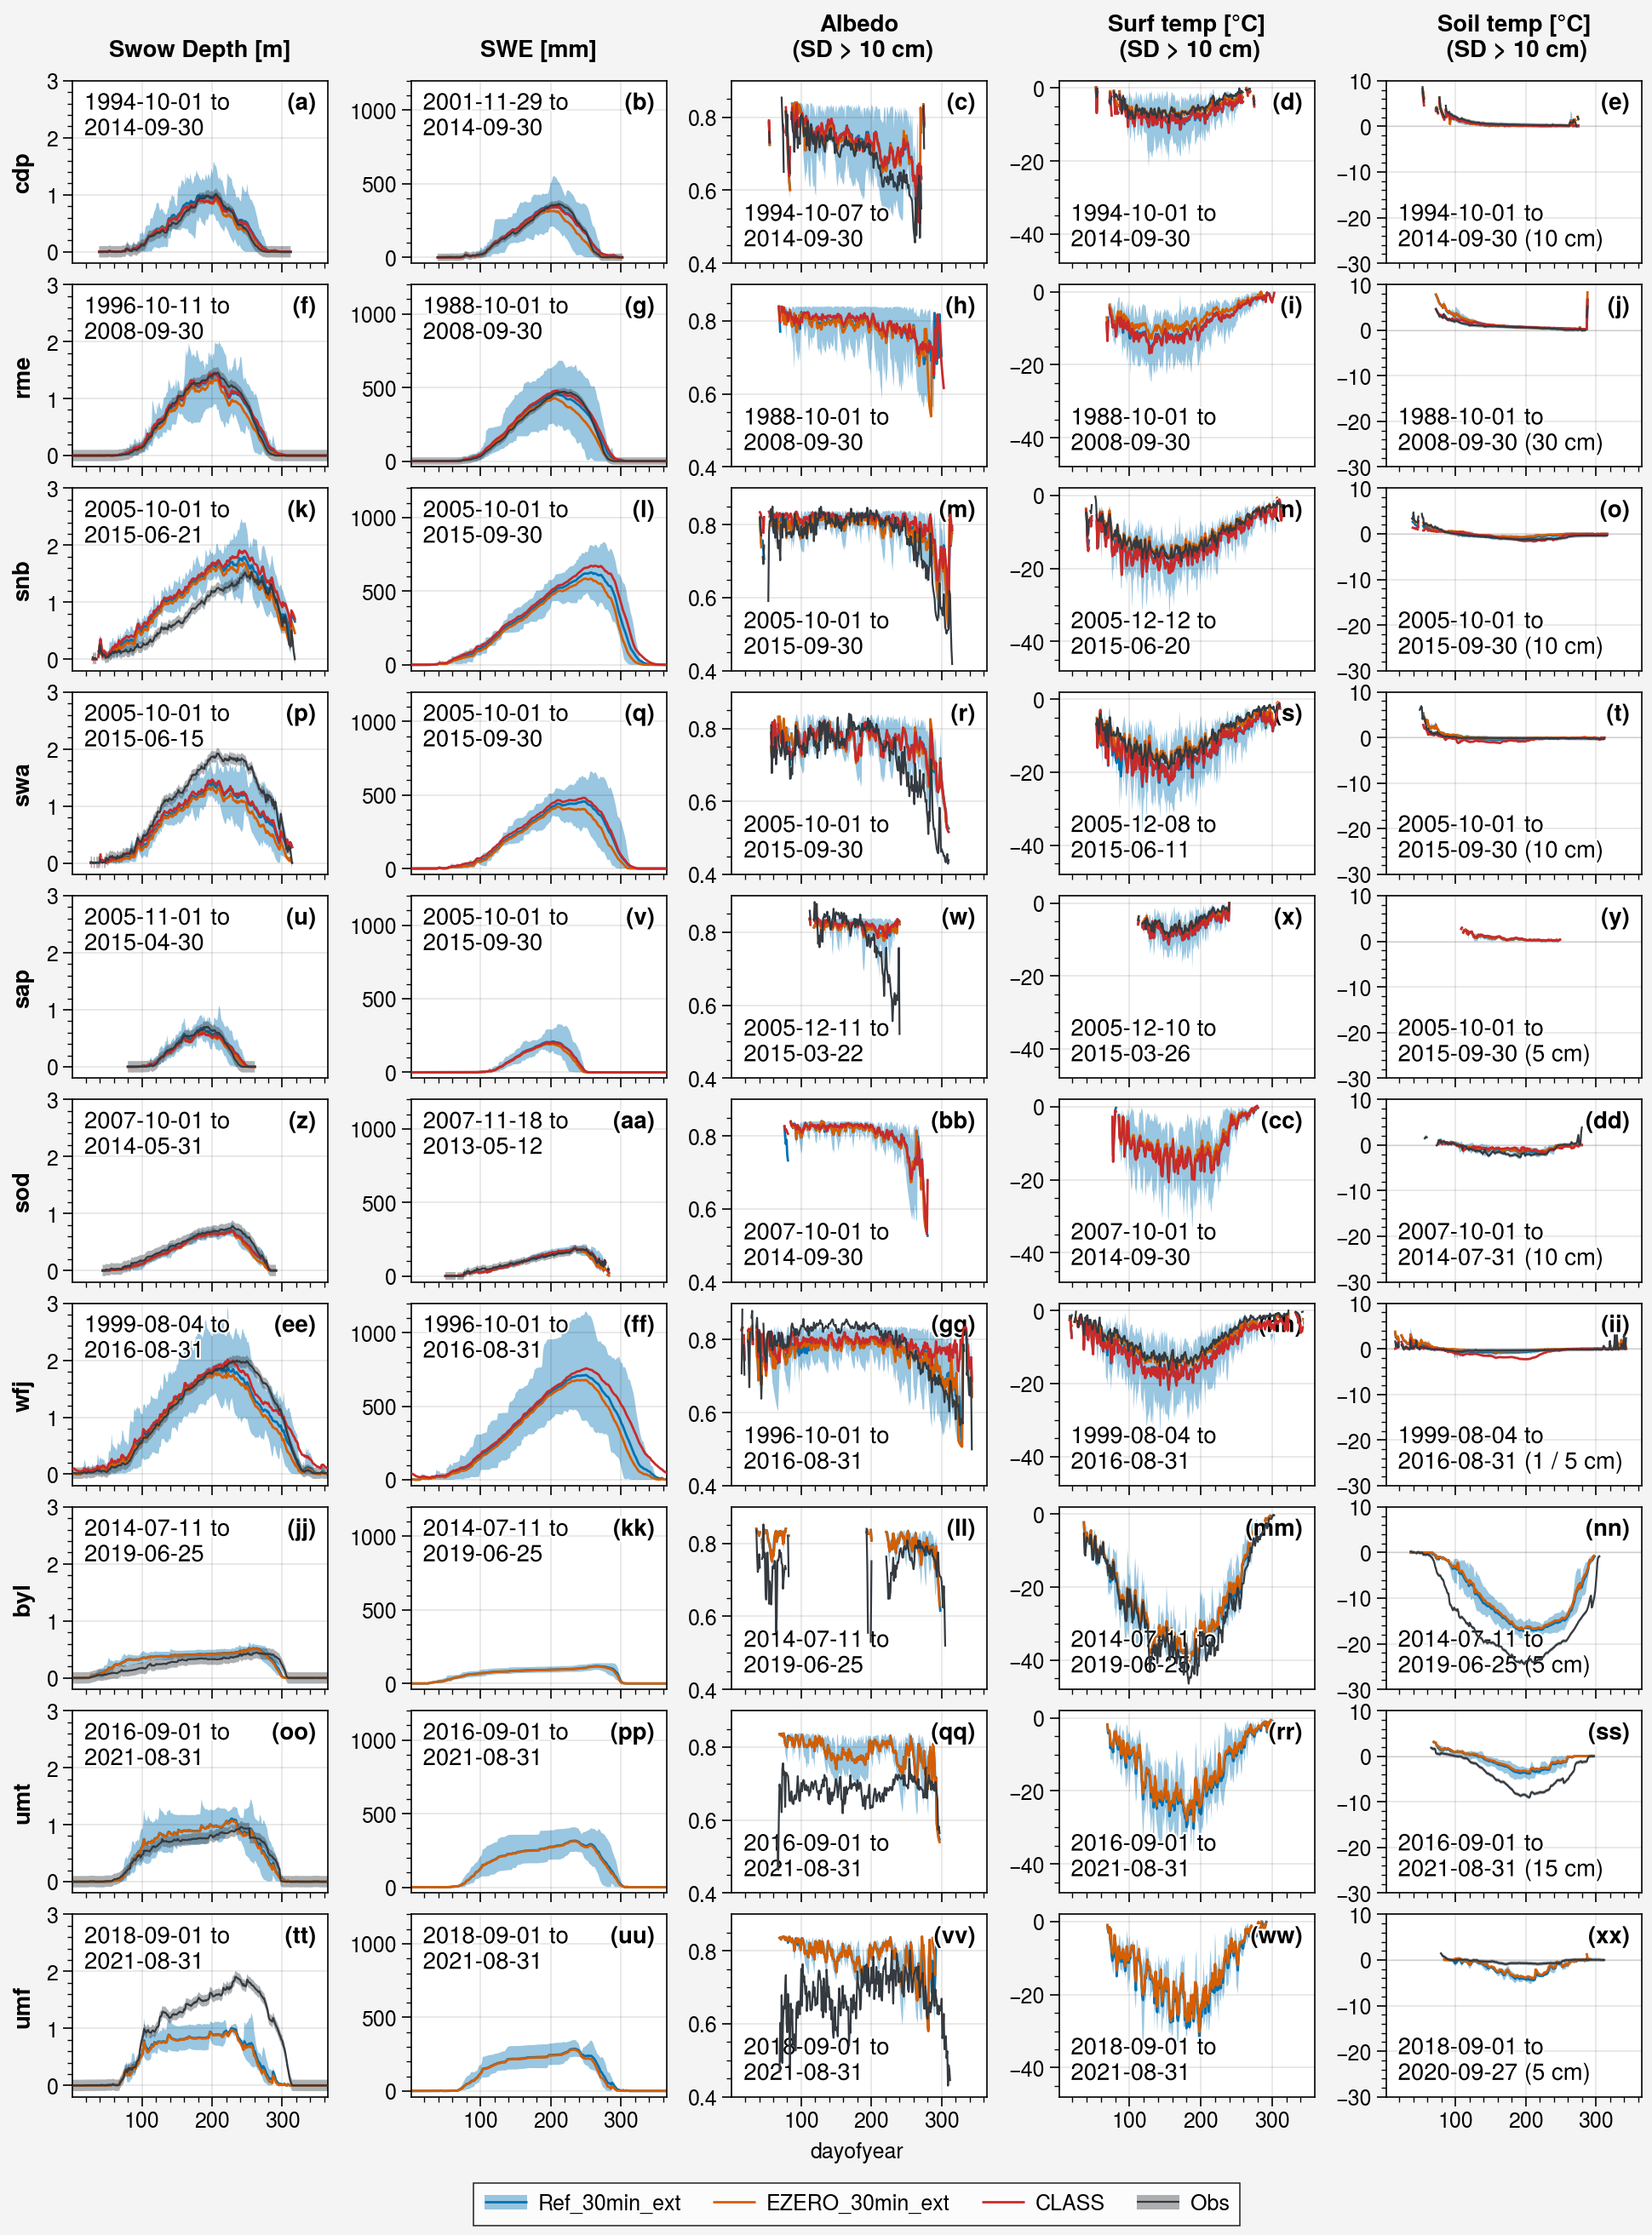

In [95]:
import warnings
warnings.filterwarnings("ignore")

color_obs = 'gray8'

# fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0)
fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0, hspace=1, refaspect=1.4)

# for i, site in enumerate([cdp]):
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):

    doy = 140
    period = site.period_used

    # Snow depth
    ax = axs[i*5+0]
    mask_obs = ~ds_d_Obs_list[i].snd_auto.sel(time=period).isnull()
    
    shadedata = ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    h1 = ax.plot(ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    h_exps = []
    for j, exp in enumerate(exps[1:]):
        h = ax.plot(ds_d_SnowMIP_list[j+1][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
        h_exps.append(h)

    if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        h_paul = ax.plot(ds_d_Paul_list[i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
    
    obs = ds_d_Obs_list[i].snd_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    shadedata = np.concatenate((np.expand_dims(obs.values+0.1, axis=0), np.expand_dims(obs.values-0.1, axis=0),), axis=0)
    h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
    ax.format(ylabel='', ylim=(-0.2,3),
              ultitle=str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
              str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[-1].values)[:10])    
    # ax.legend(h1+h_exps+h_paul+h_obs, loc='ul', ncols=1)
    
    # Snow Water Equivalent
    ax = axs[i*5+1]

    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].snw_auto.sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].snw_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+25, axis=0), np.expand_dims(obs.values-25, axis=0),), axis=0)
        h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-40,1200),
                  ultitle=str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-40,1200), ultitle=period.start+' to\n'+ period.stop)


    # Albedo (need to add a condition albsn > 0.4 because a few values are 0 in the model -> bug? (e.g., at Saporo)
    # + low values are observed in the begining of the season (probably due to not full SCF coveraged)
    ax = axs[i*5+2]
    lim_alb = 0.4
    lim_alb_sup = 0.9

    if 'albs' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > lim_alb).where(ds_d_Obs_list[i].albs < lim_alb_sup)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                     .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
                            .where(ds_d_Paul_list[i].albsn < lim_alb_sup)\
                            .where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                            .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].albs.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(0.4,0.9),
                  lltitle=str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
                             .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                            .where(ds_d_Paul_list[i].snd > 0.1).groupby('time.dayofyear').mean()\
                            .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(0.4,0.9), lltitle=period.start+' to\n'+ period.stop)
    
    
    # Surface temperature
    # Add condition on ts <= 0 on obs to avoid melting pachy areas to be counted
    ax = axs[i*5+3]

    if 'ts' in list(ds_d_Obs_list[i].keys()) and ds_d_Obs_list[i].ts.notnull().sum() != 0:
        mask_obs = ~ds_d_Obs_list[i].ts.sel(time=period).where(ds_d_Obs_list[i].ts <= 0)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].ts.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-48,2),
                  lltitle=str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-48,2), lltitle=period.start+' to\n'+ period.stop)

    
    # Soil temperature
    ax = axs[i*5+4]

    if 'tsl' in list(ds_d_Obs_list[i].keys()):
        
        # Get the first soil layer from obs (except for byl)
        if site.name == 'byl':
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0) # 0.05 instead of 0.02
        else:
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0)

        # For wfj (otherwise NaN so take the first model level)
        if obs_sdepth < 0.01: 
            model_sdepth = 0.05
        else:
            model_sdepth = obs_sdepth
        mask_obs = ~ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()

        # Interp model on the first soil layer obs
        if obs_sdepth < 0.01: 
            ds_d_interp = ds_d_SnowMIP_list[0][i]
        else:
            ds_d_interp = ds_d_SnowMIP_list[0][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
        
        shadedata = ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            if obs_sdepth < 0.01: 
                ds_d_interp = ds_d_SnowMIP_list[j+1][i]
            else:
                ds_d_interp = ds_d_SnowMIP_list[j+1][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            
            h = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            if obs_sdepth < 0.01: 
                ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
            else:
                ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        obs = ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+0.4, axis=0), np.expand_dims(obs.values-0.4, axis=0),), axis=0)
        h_obs = ax.plot(obs, label='Obs', shadedata=shadedata, color=color_obs, lw=0.8, zorder=10)
        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        if site.name == 'byl':
            ylim=(-30, 10)
        else:
            ylim=(-30, 10)
            # ylim=(-5, 10)
        if obs_sdepth != model_sdepth: 
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' / '+str(round(model_sdepth*100))+' cm)') 
        else:
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' cm)')

    else:
        model_sdepth = 0.05 # first level
        
        shadedata = ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):            
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
            h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        ax.format(ylabel='', ylim=ylim, lltitle=period.start+' to\n'+ period.stop+' ('+\
                     str(round(model_sdepth*100))+' cm)')
    
    
# for ax in axs:
#     ax.format(xlim=(40,350))
    
fig.format(abc='(a)', abcloc='ur', 
           collabels=['Swow Depth [m]', 'SWE [mm]', 'Albedo\n (SD > 10 cm)', 'Surf temp [°C]\n (SD > 10 cm)', 
                      'Soil temp [°C]\n (SD > 10 cm)'],
           rowlabels=[site.name for site in SnowMIP_sites+SnowArctic_sites])
fig.legend(h1+h_exps+h_paul+h_obs, loc='b', ncols=5)

fig.save('img/tn1_ac.jpg')


## Metrics

## Time series

In [96]:
def mb(simu, obs):
    return (simu-obs).mean().values.item(0)

def rmb(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean())).values.item(0)*100
    
def mab(simu, obs):
    return (np.abs(simu-obs)).mean().values.item(0)

def rmab(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean())).values.item(0)*100
    
def rmse(simu, obs):
    return np.sqrt(((simu-obs)**2).mean()).values.item(0)

def rrmse(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean())).values.item(0)*100
    
def corr(simu, obs):
    return xr.corr(simu, obs).values.item(0)

In [97]:
def mb_a(simu, obs):
    return (simu-obs).mean()

def rmb_a(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean()))*100
    
def mab_a(simu, obs):
    return (np.abs(simu-obs)).mean()

def rmab_a(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean()))*100
    
def rmse_a(simu, obs):
    return np.sqrt(((simu-obs)**2).mean())

def rrmse_a(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean()))*100
    
def corr_a(simu, obs):
    r, _ = stats.pearsonr(simu, obs)
    return r

In [98]:
# Can be negative if rmse > std
def calculate_score(std_deviation, rmse):
    return (std_deviation - rmse) / std_deviation

In [99]:
['Obs'] + [site.name for site in SnowMIP_sites]

['Obs', 'cdp', 'rme', 'snb', 'swa', 'sap', 'sod', 'wfj']

In [100]:
exps

['Ref_30min_ext', 'EZERO_30min_ext']

In [101]:
df_metrics_list = []
column_indexes = ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']

for site in SnowMIP_sites+SnowArctic_sites:
    row_indexes = [['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD'], 
                   ['Obs', 'CLASS']+exps]
    rows = pd.MultiIndex.from_product(row_indexes)
    
    df_metrics = pd.DataFrame(index=rows, columns=column_indexes)
    df_metrics_list.append(df_metrics)
    
df_metrics_list[0]

mb  rmb  nmb  mab rmab rmse rrmse nrmse    r stdd  \
snd_auto Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
snd_man  Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
snw_auto Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
snw_man  Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
albs     Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
ts       Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
tsl      Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
tsn      Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
SCD      Obs              NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         CLASS            NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         Ref_30min_ext    NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   
         EZERO_30min_ext  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN   

                         score  
snd_auto Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
snd_man  Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
snw_auto Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
snw_man  Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
albs     Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
ts       Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
tsl      Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         EZERO_30min_ext   NaN  
tsn      Obs               NaN  
         CLASS             NaN  
         Ref_30min_ext     NaN  
         E

In [103]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl']:

        if site.name in ['byl', 'umt', 'umf']:
            arr1 = ['Obs']+exps
            arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
        else:
            arr1 = ['Obs', 'CLASS']+exps
            arr2 = [ds_d_Obs_list[i], ds_d_Paul_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            # We are going to make a common mask based on snd_auto so the comparison will be on the same period (auto/man)
            mask_obs_snd = ~ds_d_Obs_list[i].snd_auto.where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
            if exp == 'Obs':
                if var == 'snd_auto':
                    obs = ds_d_Obs_list[i].snd_auto.where(mask_obs_snd).sel(time=period)
                    simu = obs
                elif var == 'snd_man':
                    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].snd_man.where(ds_d_Obs_list[i].snd_man > 0.1).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].snd_man.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_auto':
                    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_auto.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_man':
                    if 'snw_man' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_man.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'albs':
                    if 'albs' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > 0.4)\
                                    .where(ds_d_Obs_list[i].albs < 0.9).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].albs.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'ts':
                    if 'ts' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].ts.where(ds_d_Obs_list[i].ts <= 0).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].ts.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Get the first soil layer from obs
                        if site.name == 'byl':
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0)
                        else:
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0) 
                        obs = ds_d_Obs_list[i].tsl.where(mask_obs_snd).sel(time=period, sdepth=obs_sdepth)
                        simu = obs
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")
                    
            # Model
            else:
                if var in ['snd_auto', 'snd_man']:
                    simu = ds_simu.snd.where(obs.notnull()).sel(time=period)
                elif var in ['snw_auto', 'snw_man']:
                    simu = ds_simu.snw.where(obs.notnull()).sel(time=period)
                elif var == 'albs':
                    simu = ds_simu['albsn'].where(ds_simu.albsn > 0.4).where(ds_simu.albsn < 0.9).where(obs.notnull())\
                            .sel(time=period)
                elif var == 'ts':
                    simu = ds_simu[var].where(obs.notnull()).sel(time=period)-273.15
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Interp model on the first soil layer obs
                        if obs_sdepth < 0.01: 
                            ds_d_interp = ds_simu[var]
                            model_sdepth = 0.05
                        else:
                            ds_d_interp = ds_simu[var].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
                            model_sdepth = obs_sdepth
                        simu = ds_d_interp.where(obs.notnull()).sel(time=period, layer=model_sdepth)-273.15
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")

            if var in list(ds_d_Obs_list[i].keys()):
                df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
                df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
                df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
                df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
                df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))

            
df_metrics_list[0]

mb        rmb       nmb        mab  \
snd_auto Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.009459   1.368081  0.024033    0.13858   
         Ref_30min_ext     0.055939   8.091017  0.142137   0.141386   
         EZERO_30min_ext  -0.028604  -4.137293 -0.072681   0.139143   
snd_man  Obs                    0.0        0.0       0.0        0.0   
         CLASS            -0.072323  -8.546966 -0.188631   0.151771   
         Ref_30min_ext     -0.01989   -2.35059 -0.051877   0.134605   
         EZERO_30min_ext  -0.108274 -12.795652 -0.282399   0.161436   
snw_auto Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.663599   0.263542  0.004953  36.160334   
         Ref_30min_ext       4.7307   1.878753  0.035313  36.669004   
         EZERO_30min_ext -24.551591  -9.750433 -0.183267  48.138253   
snw_man  Obs                    0.0        0.0       0.0        0.0   
         CLASS            20.691173   7.515338  0.144194  42.718746   
         Ref_30min_ext     27.50772   9.991208  0.191698  47.195024   
         EZERO_30min_ext  -6.193465  -2.249557 -0.043161  42.365078   
albs     Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.040365   5.844651  0.423158   0.066434   
         Ref_30min_ext     0.039228   5.679901   0.41123   0.063436   
         EZERO_30min_ext   0.032439   4.696975  0.340065   0.062956   
ts       Obs                    0.0        0.0       0.0        0.0   
         CLASS             -1.88054 -33.585045 -0.441068   2.356576   
         Ref_30min_ext    -1.885843 -33.679752 -0.442312   2.432872   
         EZERO_30min_ext   -0.20079   -3.58596 -0.047094   1.288303   
tsl      Obs                    0.0        0.0       0.0        0.0   
         CLASS            -0.212484 -35.695396 -0.328872   0.299352   
         Ref_30min_ext    -0.294086 -49.403956 -0.455173   0.324568   
         EZERO_30min_ext  -0.258372 -43.404193 -0.399896    0.30626   
tsn      Obs                    NaN        NaN       NaN        NaN   
         CLASS                  NaN        NaN       NaN        NaN   
         Ref_30min_ext          NaN        NaN       NaN        NaN   
         EZERO_30min_ext        NaN        NaN       NaN        NaN   
SCD      Obs                    NaN        NaN       NaN        NaN   
         CLASS                  NaN        NaN       NaN        NaN   
         Ref_30min_ext          NaN        NaN       NaN        NaN   
         EZERO_30min_ext        NaN        NaN       NaN        NaN   

                               rmab       rmse      rrmse     nrmse         r  \
snd_auto Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            20.044278   0.176747  25.564703  0.449101  0.894059   
         Ref_30min_ext     20.45012    0.18286  26.448861  0.464633  0.898405   
         EZERO_30min_ext  20.125618   0.182216  26.355803  0.462998  0.889632   
snd_man  Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            17.936027   0.189795  22.429687  0.495021  0.889394   
         Ref_30min_ext    15.907334   0.169523  20.033981  0.442148  0.899277   
         EZERO_30min_ext  19.078201   0.205934  24.336974  0.537115  0.889865   
snw_auto Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            14.360736  47.097693  18.704405  0.351564  0.944043   
         Ref_30min_ext     14.56275  47.152057  18.725995   0.35197   0.94629   
         EZERO_30min_ext  19.117654  64.066387  25.443362  0.478228  0.904846   
snw_man  Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            15.516075  56.040056   20.35457  0.390536  0.933405   
         Ref_30min_ext    17.141925  60.486467  21.969572  0.421523  0.930101   
         EZERO_30min_ext  15.387618   58.87239  21.383316  0.410274  0.913596   
albs     Obs                

In [104]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['SCD']:
        
        if site.name in ['byl', 'umt', 'umf']:
            arr1 = ['Obs']+exps
            arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
        else:
            arr1 = ['Obs', 'CLASS']+exps
            arr2 = [ds_d_Obs_list[i], ds_d_Paul_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            mask = ds_d_Obs_list[i].snd_auto > 0.1
            obs = ds_d_Obs_list[i].snd_auto.where(mask).sel(time=period).notnull()\
                    .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum()
            obs = obs.where(obs > 0)
            if exp == 'Obs':
                simu = obs
            else:
                simu = ds_simu.snd.where(ds_simu.snd > 0.1).sel(time=period).notnull()\
                        .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum().where(obs.notnull())
    
            df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))
            
df_metrics_list[0]

mb        rmb       nmb        mab  \
snd_auto Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.009459   1.368081  0.024033    0.13858   
         Ref_30min_ext     0.055939   8.091017  0.142137   0.141386   
         EZERO_30min_ext  -0.028604  -4.137293 -0.072681   0.139143   
snd_man  Obs                    0.0        0.0       0.0        0.0   
         CLASS            -0.072323  -8.546966 -0.188631   0.151771   
         Ref_30min_ext     -0.01989   -2.35059 -0.051877   0.134605   
         EZERO_30min_ext  -0.108274 -12.795652 -0.282399   0.161436   
snw_auto Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.663599   0.263542  0.004953  36.160334   
         Ref_30min_ext       4.7307   1.878753  0.035313  36.669004   
         EZERO_30min_ext -24.551591  -9.750433 -0.183267  48.138253   
snw_man  Obs                    0.0        0.0       0.0        0.0   
         CLASS            20.691173   7.515338  0.144194  42.718746   
         Ref_30min_ext     27.50772   9.991208  0.191698  47.195024   
         EZERO_30min_ext  -6.193465  -2.249557 -0.043161  42.365078   
albs     Obs                    0.0        0.0       0.0        0.0   
         CLASS             0.040365   5.844651  0.423158   0.066434   
         Ref_30min_ext     0.039228   5.679901   0.41123   0.063436   
         EZERO_30min_ext   0.032439   4.696975  0.340065   0.062956   
ts       Obs                    0.0        0.0       0.0        0.0   
         CLASS             -1.88054 -33.585045 -0.441068   2.356576   
         Ref_30min_ext    -1.885843 -33.679752 -0.442312   2.432872   
         EZERO_30min_ext   -0.20079   -3.58596 -0.047094   1.288303   
tsl      Obs                    0.0        0.0       0.0        0.0   
         CLASS            -0.212484 -35.695396 -0.328872   0.299352   
         Ref_30min_ext    -0.294086 -49.403956 -0.455173   0.324568   
         EZERO_30min_ext  -0.258372 -43.404193 -0.399896    0.30626   
tsn      Obs                    NaN        NaN       NaN        NaN   
         CLASS                  NaN        NaN       NaN        NaN   
         Ref_30min_ext          NaN        NaN       NaN        NaN   
         EZERO_30min_ext        NaN        NaN       NaN        NaN   
SCD      Obs                    0.0        0.0       0.0        0.0   
         CLASS                 18.3  13.203463   0.79918       18.3   
         Ref_30min_ext        17.05  12.301587  0.744591      18.05   
         EZERO_30min_ext        8.5   6.132756  0.371204       11.6   

                               rmab       rmse      rrmse     nrmse         r  \
snd_auto Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            20.044278   0.176747  25.564703  0.449101  0.894059   
         Ref_30min_ext     20.45012    0.18286  26.448861  0.464633  0.898405   
         EZERO_30min_ext  20.125618   0.182216  26.355803  0.462998  0.889632   
snd_man  Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            17.936027   0.189795  22.429687  0.495021  0.889394   
         Ref_30min_ext    15.907334   0.169523  20.033981  0.442148  0.899277   
         EZERO_30min_ext  19.078201   0.205934  24.336974  0.537115  0.889865   
snw_auto Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            14.360736  47.097693  18.704405  0.351564  0.944043   
         Ref_30min_ext     14.56275  47.152057  18.725995   0.35197   0.94629   
         EZERO_30min_ext  19.117654  64.066387  25.443362  0.478228  0.904846   
snw_man  Obs                    0.0        0.0        0.0       0.0       1.0   
         CLASS            15.516075  56.040056   20.35457  0.390536  0.933405   
         Ref_30min_ext    17.141925  60.486467  21.969572  0.421523  0.930101   
         EZERO_30min_ext  15.387618   58.87239  21.383316  0.410274  0.913596   
albs     Obs                

In [ ]:
df_metrics_list[-1]

## Menard plot
https://journals.ametsoc.org/view/journals/bams/102/1/BAMS-D-19-0329.1.xml

In [105]:
# For calculating the mean of each site
df_gather = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        for exp in ['Obs', 'CLASS']+exps:
            array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites)])
            df_gather.loc[(var, exp), metric] = array_gather

df_gather_Arctic = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        for exp in ['Obs', 'CLASS']+exps:
            if exp == 'CLASS':
                array_gather = np.nan
            else:
                array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites+SnowArctic_sites)])
            df_gather_Arctic.loc[(var, exp), metric] = array_gather

In [67]:
df_gather.head()

mb  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [0.009458514494533833, 0.0015057351557142096, ...   
         Ref_30min_ext    [0.05593893260822275, -0.02504070856986462, 0....   
         EZERO_30min_ext  [-0.028604040156274442, -0.12713993412243269, ...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                        rmb  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [1.3680811918976763, 0.15872724337220304, 45.0...   
         Ref_30min_ext    [8.091017002761692, -2.6396691531692604, 35.99...   
         EZERO_30min_ext  [-4.137293374419426, -13.40247067300827, 27.21...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                        nmb  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [0.024033372619284434, 0.0030302481437136557, ...   
         Ref_30min_ext    [0.14213661268642133, -0.05039369664256477, 0....   
         EZERO_30min_ext  [-0.07268071068559481, -0.2558654142491856, 0....   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                        mab  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [0.1385802970525234, 0.13231292510406067, 0.41...   
         Ref_30min_ext    [0.14138616492925113, 0.1299513193457606, 0.35...   
         EZERO_30min_ext  [0.13914265564569223, 0.17528109076216616, 0.3...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                       rmab  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [20.044278419694297, 13.94778210801532, 47.582...   
         Ref_30min_ext    [20.450119640460994, 13.698833167343816, 41.43...   
         EZERO_30min_ext  [20.125618065032995, 18.477276197190807, 37.41...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                       rmse  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [0.17674690463030898, 0.16433565283083773, 0.4...   
         Ref_30min_ext    [0.18285971555617708, 0.16571059588368495, 0.4...   
         EZERO_30min_ext  [0.18221633635953205, 0.2233671154314375, 0.39...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                      rrmse  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [25.564703219580508, 17.323461607853385, 55.64...   
         Ref_30min_ext    [26.44886126174873, 17.468401386767347, 49.484...   
         EZERO_30min_ext  [26.35580278214319, 23.54626997841183, 45.4451...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                      nrmse  \
snd_auto Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS            [0.44910056655727526, 0.33072071475970416, 0.9...   
         Ref_30min_ext    [0.46463275851168023, 0.33348774760594596, 0.8...   
         EZERO_30min_ext  [0.46299798045246154, 0.44951981384915995, 0.7...   
snd_man  Obs                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                                                          r  \
snd_auto Obs              [0.9999999536321564, 0.9999999776013654, 1.000...   
         CLASS            [0.8940593714546874, 0.9442676448537572, 0.854...   
         Ref_30min_ext    [0.8984053

In [68]:
df_gather_Arctic.head()

mb  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.05593893260822275, -0.02504070856986462, 0....   
         EZERO_30min_ext  [-0.028604040156274442, -0.12713993412243269, ...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                        rmb  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [8.091017002761692, -2.6396691531692604, 35.99...   
         EZERO_30min_ext  [-4.137293374419426, -13.40247067300827, 27.21...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                        nmb  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.14213661268642133, -0.05039369664256477, 0....   
         EZERO_30min_ext  [-0.07268071068559481, -0.2558654142491856, 0....   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                        mab  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.14138616492925113, 0.1299513193457606, 0.35...   
         EZERO_30min_ext  [0.13914265564569223, 0.17528109076216616, 0.3...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                       rmab  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [20.450119640460994, 13.698833167343816, 41.43...   
         EZERO_30min_ext  [20.125618065032995, 18.477276197190807, 37.41...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                       rmse  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.18285971555617708, 0.16571059588368495, 0.4...   
         EZERO_30min_ext  [0.18221633635953205, 0.2233671154314375, 0.39...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                      rrmse  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [26.44886126174873, 17.468401386767347, 49.484...   
         EZERO_30min_ext  [26.35580278214319, 23.54626997841183, 45.4451...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                      nrmse  \
snd_auto Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.46463275851168023, 0.33348774760594596, 0.8...   
         EZERO_30min_ext  [0.46299798045246154, 0.44951981384915995, 0.7...   
snd_man  Obs                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan]   

                                                                          r  \
snd_auto Obs              [0.9999999536321564, 0.9999999776013654, 1.000...   
         CLASS                                                          NaN   
         Ref_30min_ext    [0.8984053

### RMSE

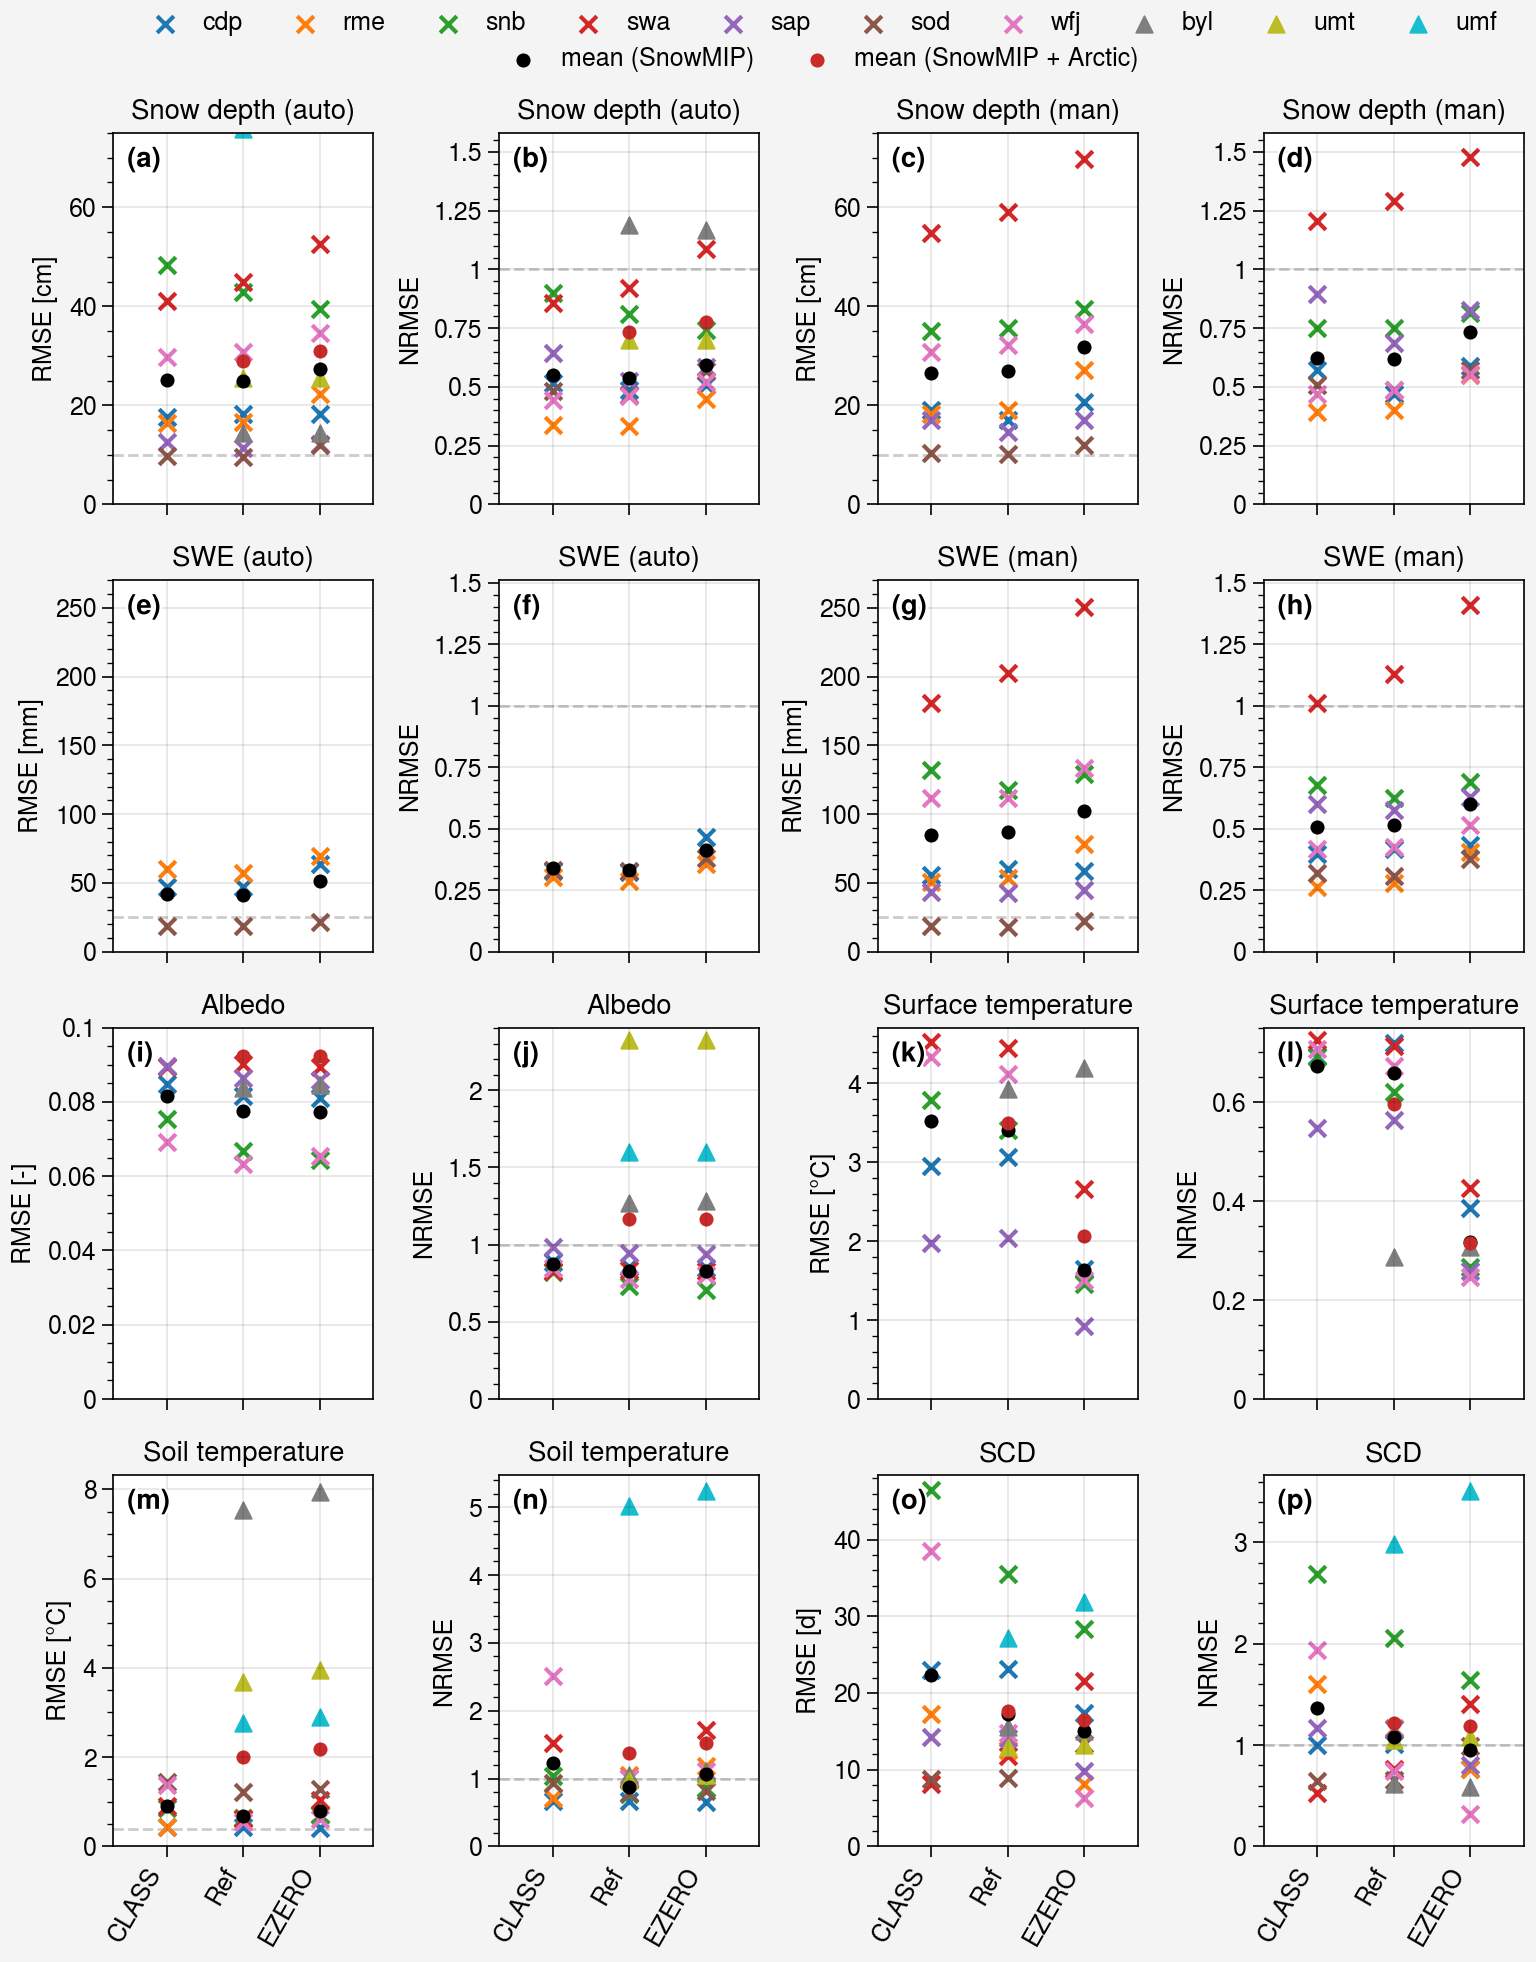

In [107]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.7, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation = 60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean (SnowMIP)'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 75))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].rmse[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].rmse[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 75))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.58))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.58))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.51))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.51))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[8].scatter(df_gather_Arctic.loc[('albs')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='RMSE [-]', xrotation=xrotation, ylim=(0, 0.1))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[9].scatter(df_gather_Arctic.loc[('albs')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='RMSE [d]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

x_min = -0.7
x_max = 2.7
for i, ax in enumerate(axs):
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    if (i % 2) != 0:
        ax.hlines(1, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Snow Depth uncertainty
axs[0].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# SWE uncertainty
axs[4].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Soil temp uncertainty
axs[12].hlines(0.4, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
fig.save('img/tn1_rmse.jpg')

### Scores

#### NRMSE

In [71]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.77081312, 0.68211608, 0.68728166])

In [72]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([       nan, 0.72143693, 0.73290302])

#### Score (no weights)

In [73]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.22918688, 0.31788392, 0.31271834])

In [74]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([       nan, 0.27856307, 0.26709698])

#### Score (weights)

In [973]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    weight = np.nansum(df_gather.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.20254069, 0.29776165, 0.28759552])

In [974]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([       nan, 0.27891356, 0.26841725])

In [976]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.11166825, 0.23874582, 0.25383291])

In [975]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([       nan, 0.22780483, 0.23948464])

### Mean bias

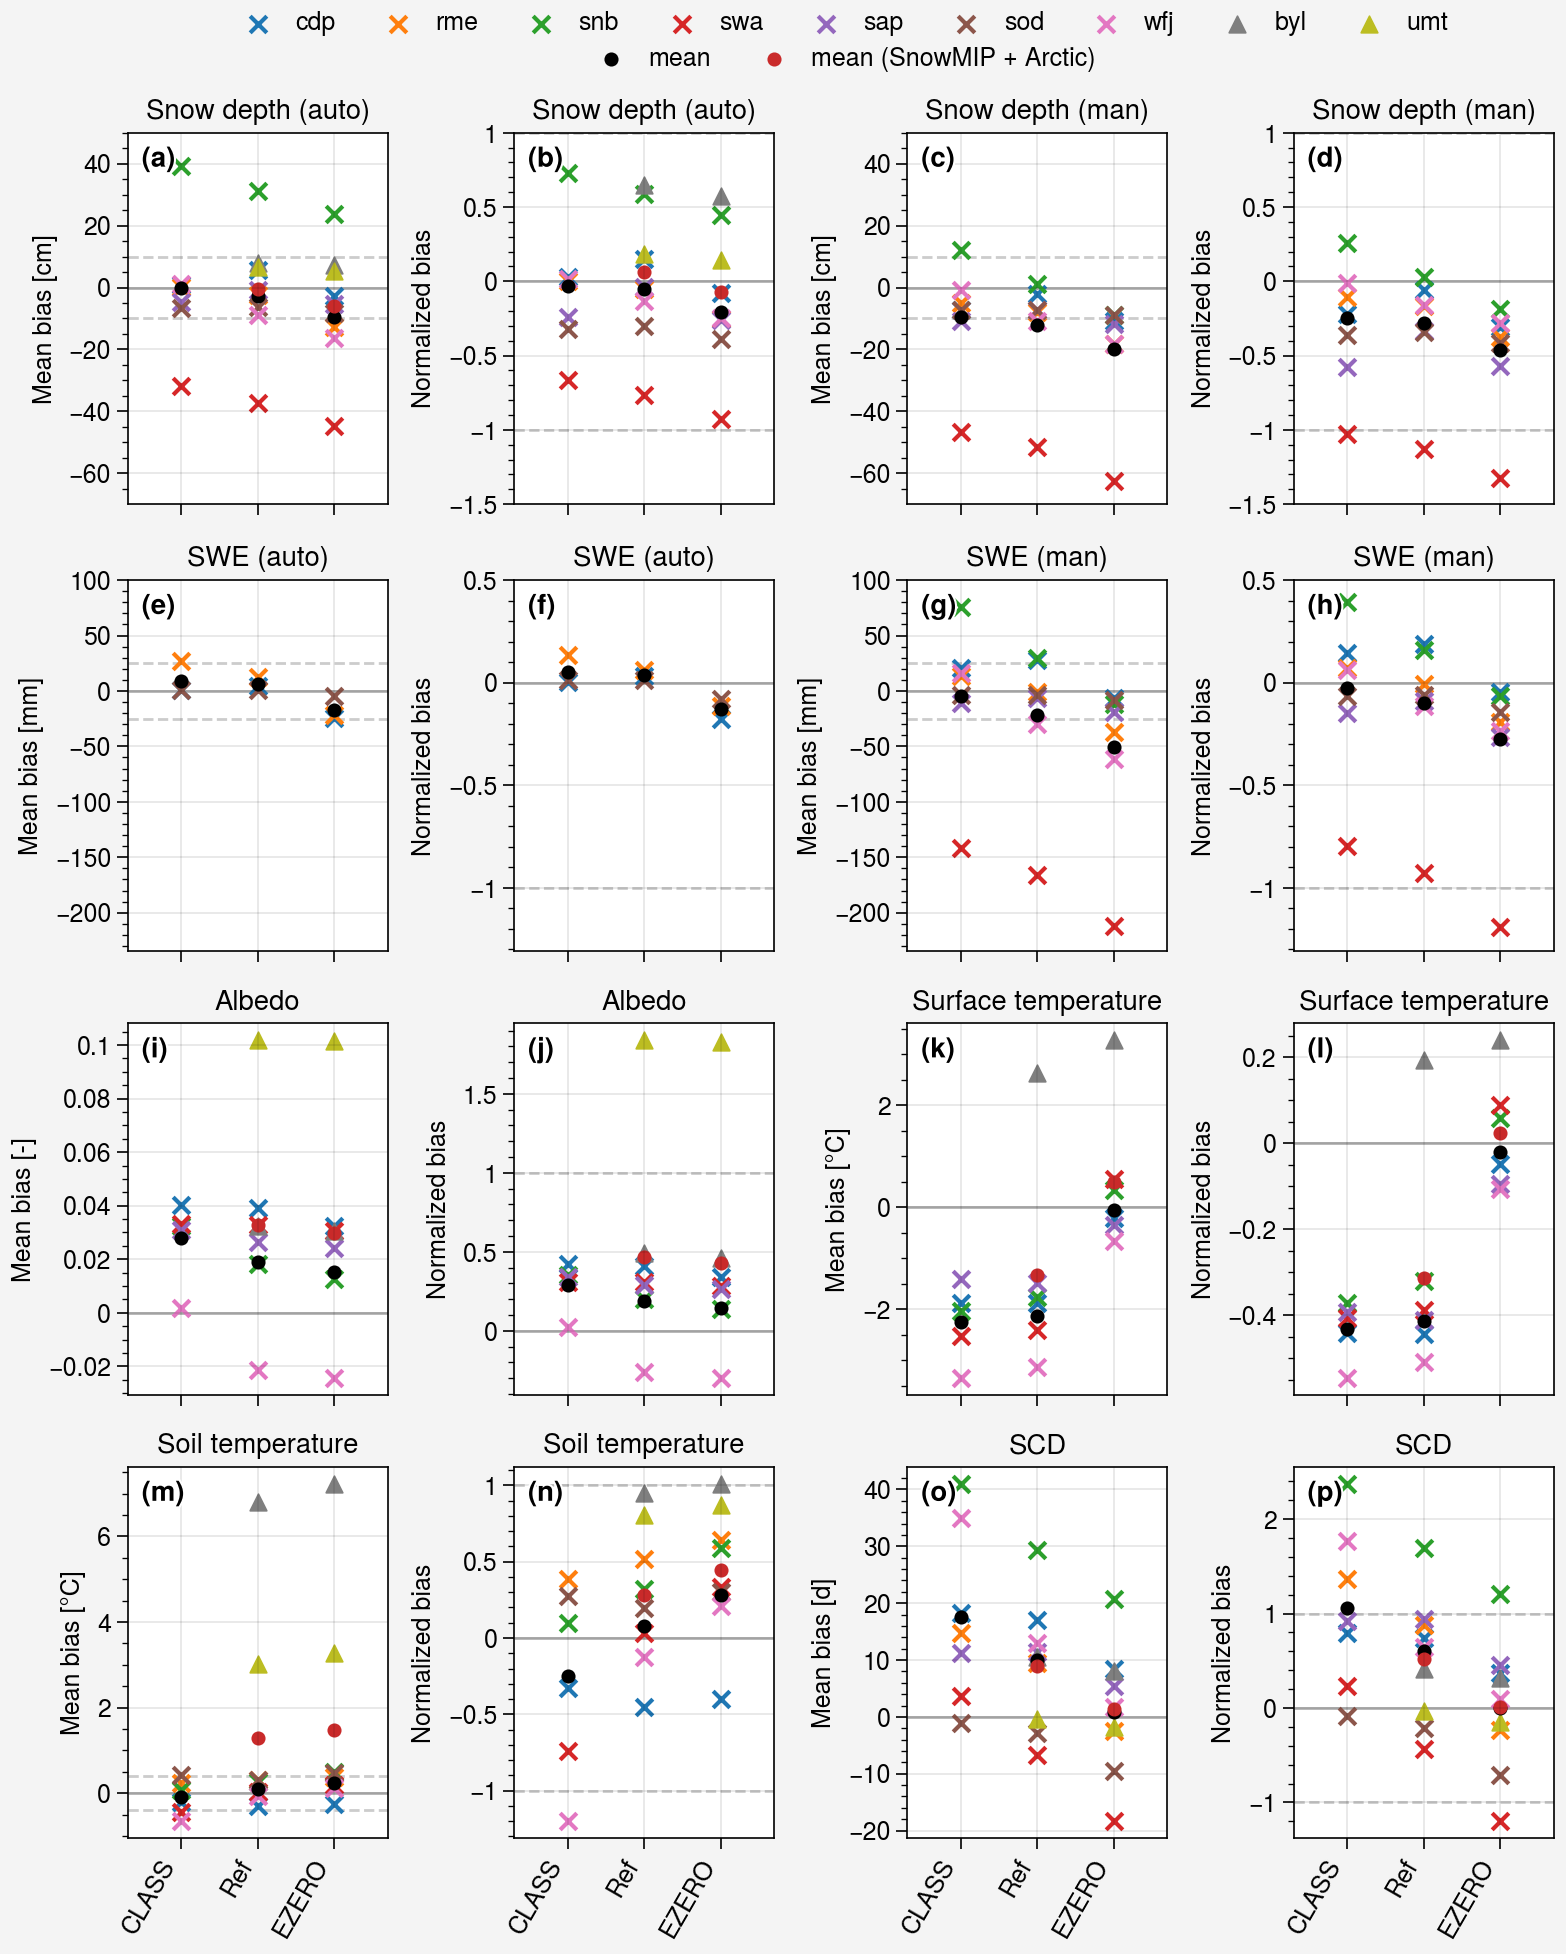

In [75]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.7, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation=60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-70, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].mb[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].mb[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-70, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nmb[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 1))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 1))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].mb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[8].scatter(df_gather_Arctic.loc[('albs')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='Mean bias [-]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[9].scatter(df_gather_Arctic.loc[('albs')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='Mean bias [d]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

x_min = -0.7
x_max = 2.7
for ax in axs:
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.hlines(0, x_min, x_max, color='k', lw=1, alpha=0.3, zorder=0, ls='-')

# Obs uncertainties (base on Lejeune et al. (2019) at cdp)
axs[0].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[4].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[12].hlines([-0.4, 0.4], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

for i, ax in enumerate(axs):
    if (i % 2) != 0:
        ax.hlines([-1, 1], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')


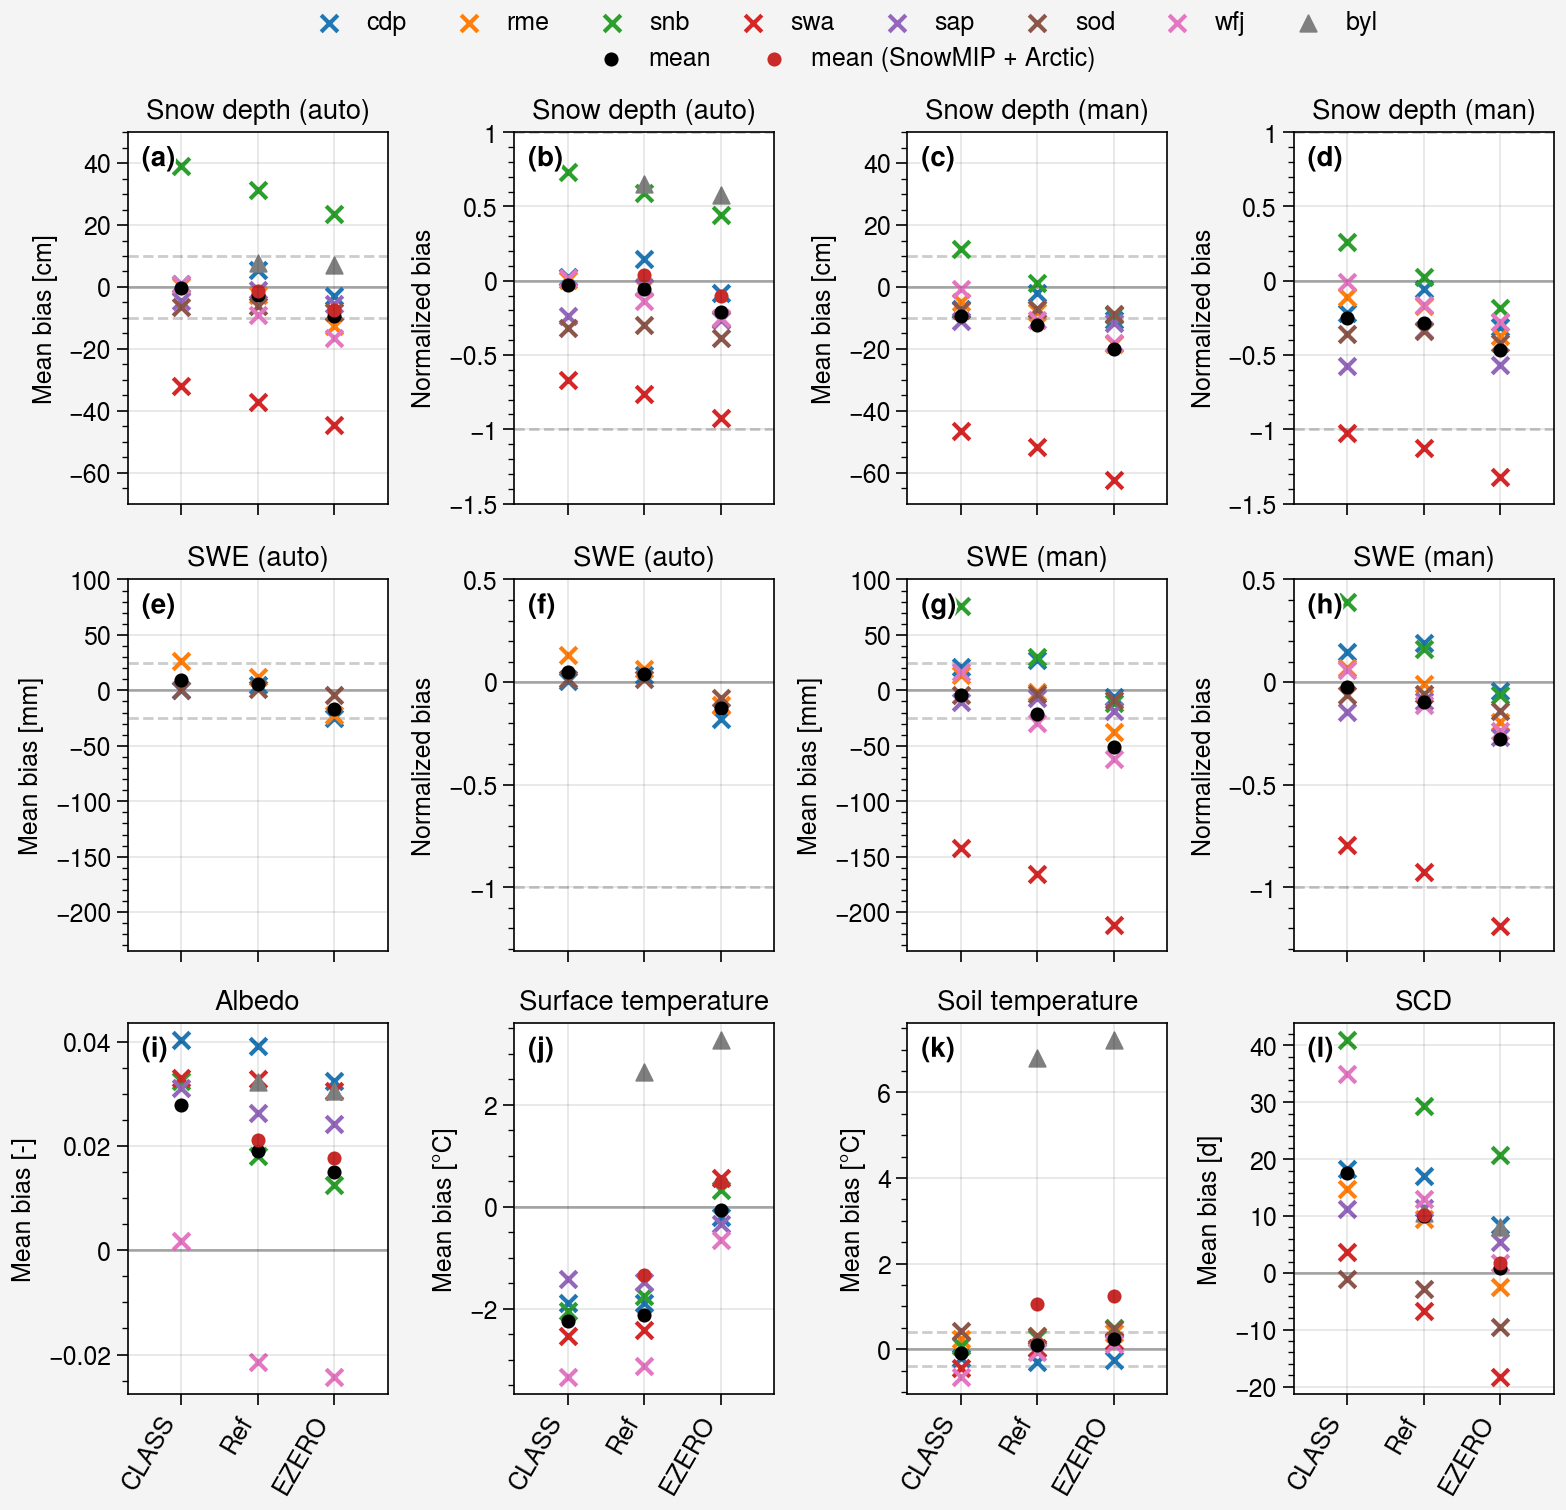

In [981]:
fig, axs = pplt.subplots(ncols=4, nrows=3, sharey=0, refaspect=0.7, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation=60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean'; color_mean='k'; marker_mean_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-70, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].mb[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].mb[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-70, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nmb[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 1))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 1))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].mb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[8].scatter(df_gather_Arctic.loc[('albs')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='Mean bias [-]', xrotation=xrotation, ylim=(None, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('ts')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('ts')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[9].scatter(df_gather_Arctic.loc[('ts')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Surface temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('tsl')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('tsl')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('tsl')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Soil temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('SCD')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('SCD')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('SCD')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='SCD', ylabel='Mean bias [d]', xrotation=xrotation, ylim=(None, None))

x_min = -0.7
x_max = 2.7
for ax in axs:
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.hlines(0, x_min, x_max, color='k', lw=1, alpha=0.3, zorder=0, ls='-')

for i, ax in enumerate(axs):
    if (i % 2) != 0 and i < 8:
        ax.hlines([-1, 1], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Obs uncertainties (base on Lejeune et al. (2019) at cdp)
axs[0].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[4].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[10].hlines([-0.4, 0.4], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')


## Taylor diagram

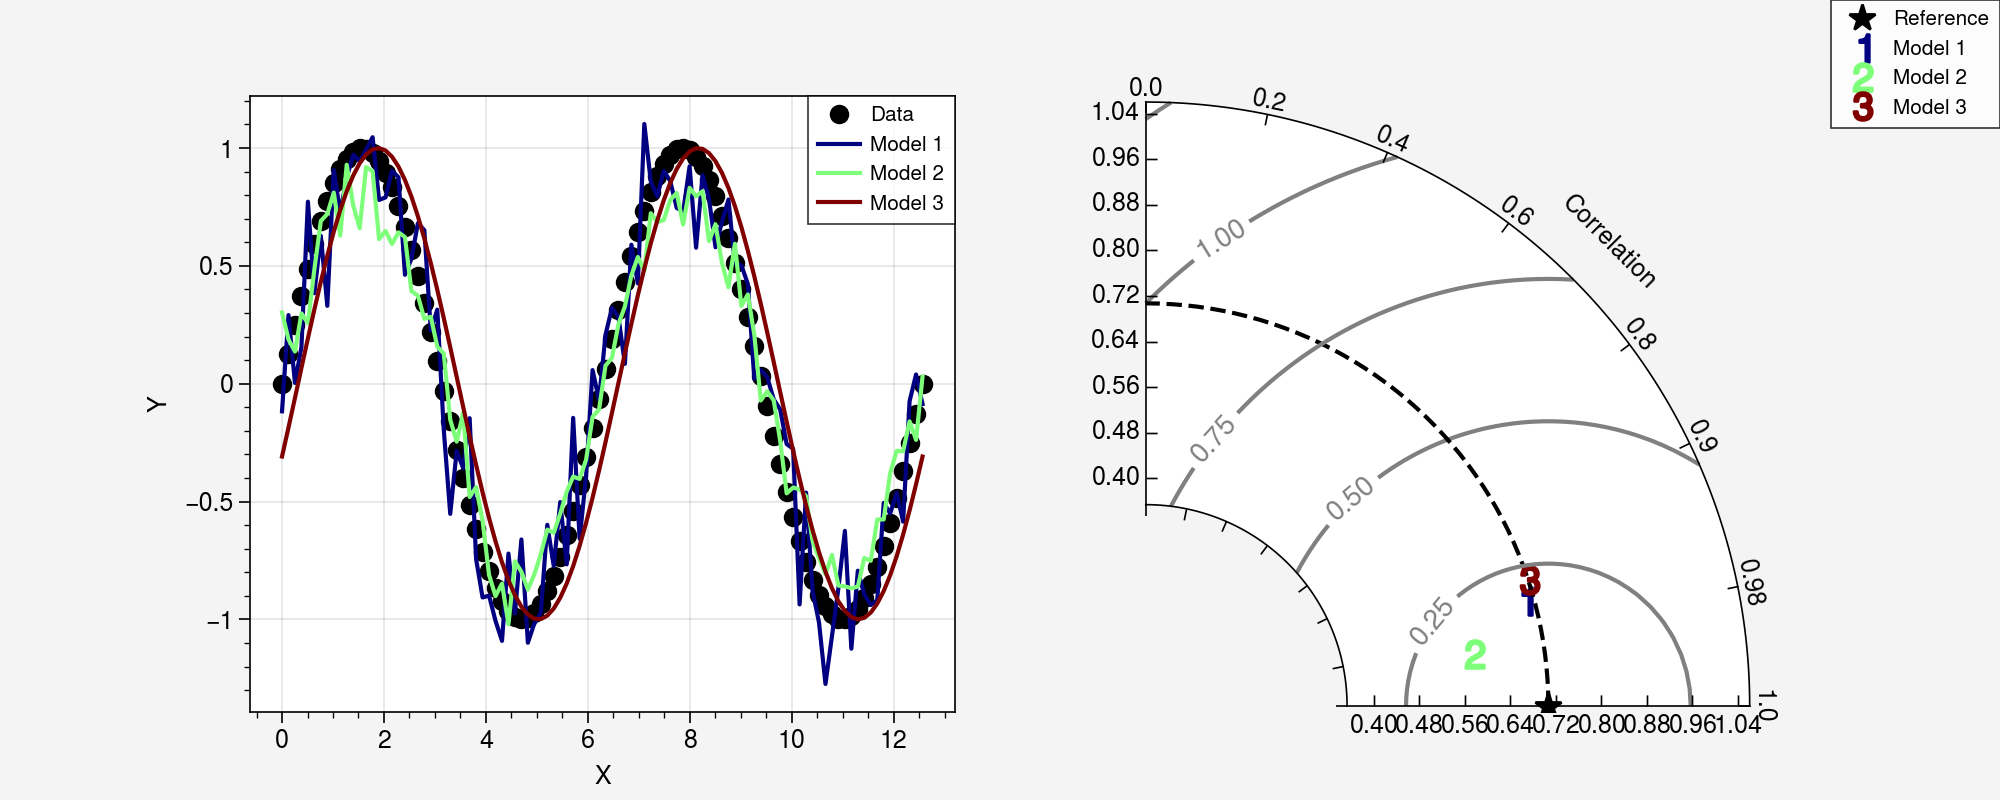

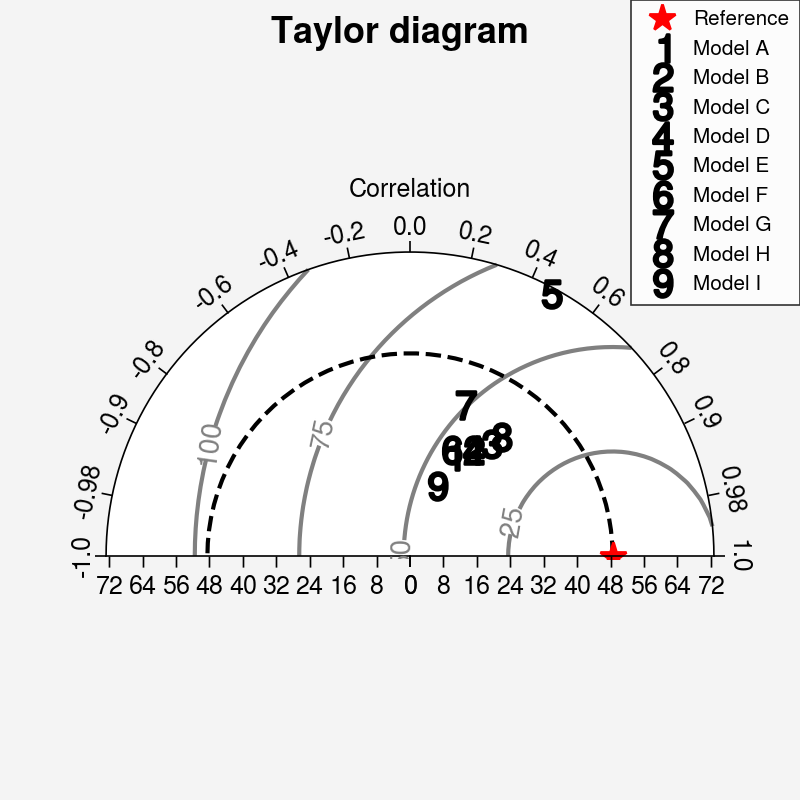

In [257]:
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.

Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
#         rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.98, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()
        
        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
#         ax.axis["left"].label.set_text("Standard Deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
#     dia = TaylorDiagram(refstd, fig=fig, rect=(1, 2, 2), label="Reference",
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0.5, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

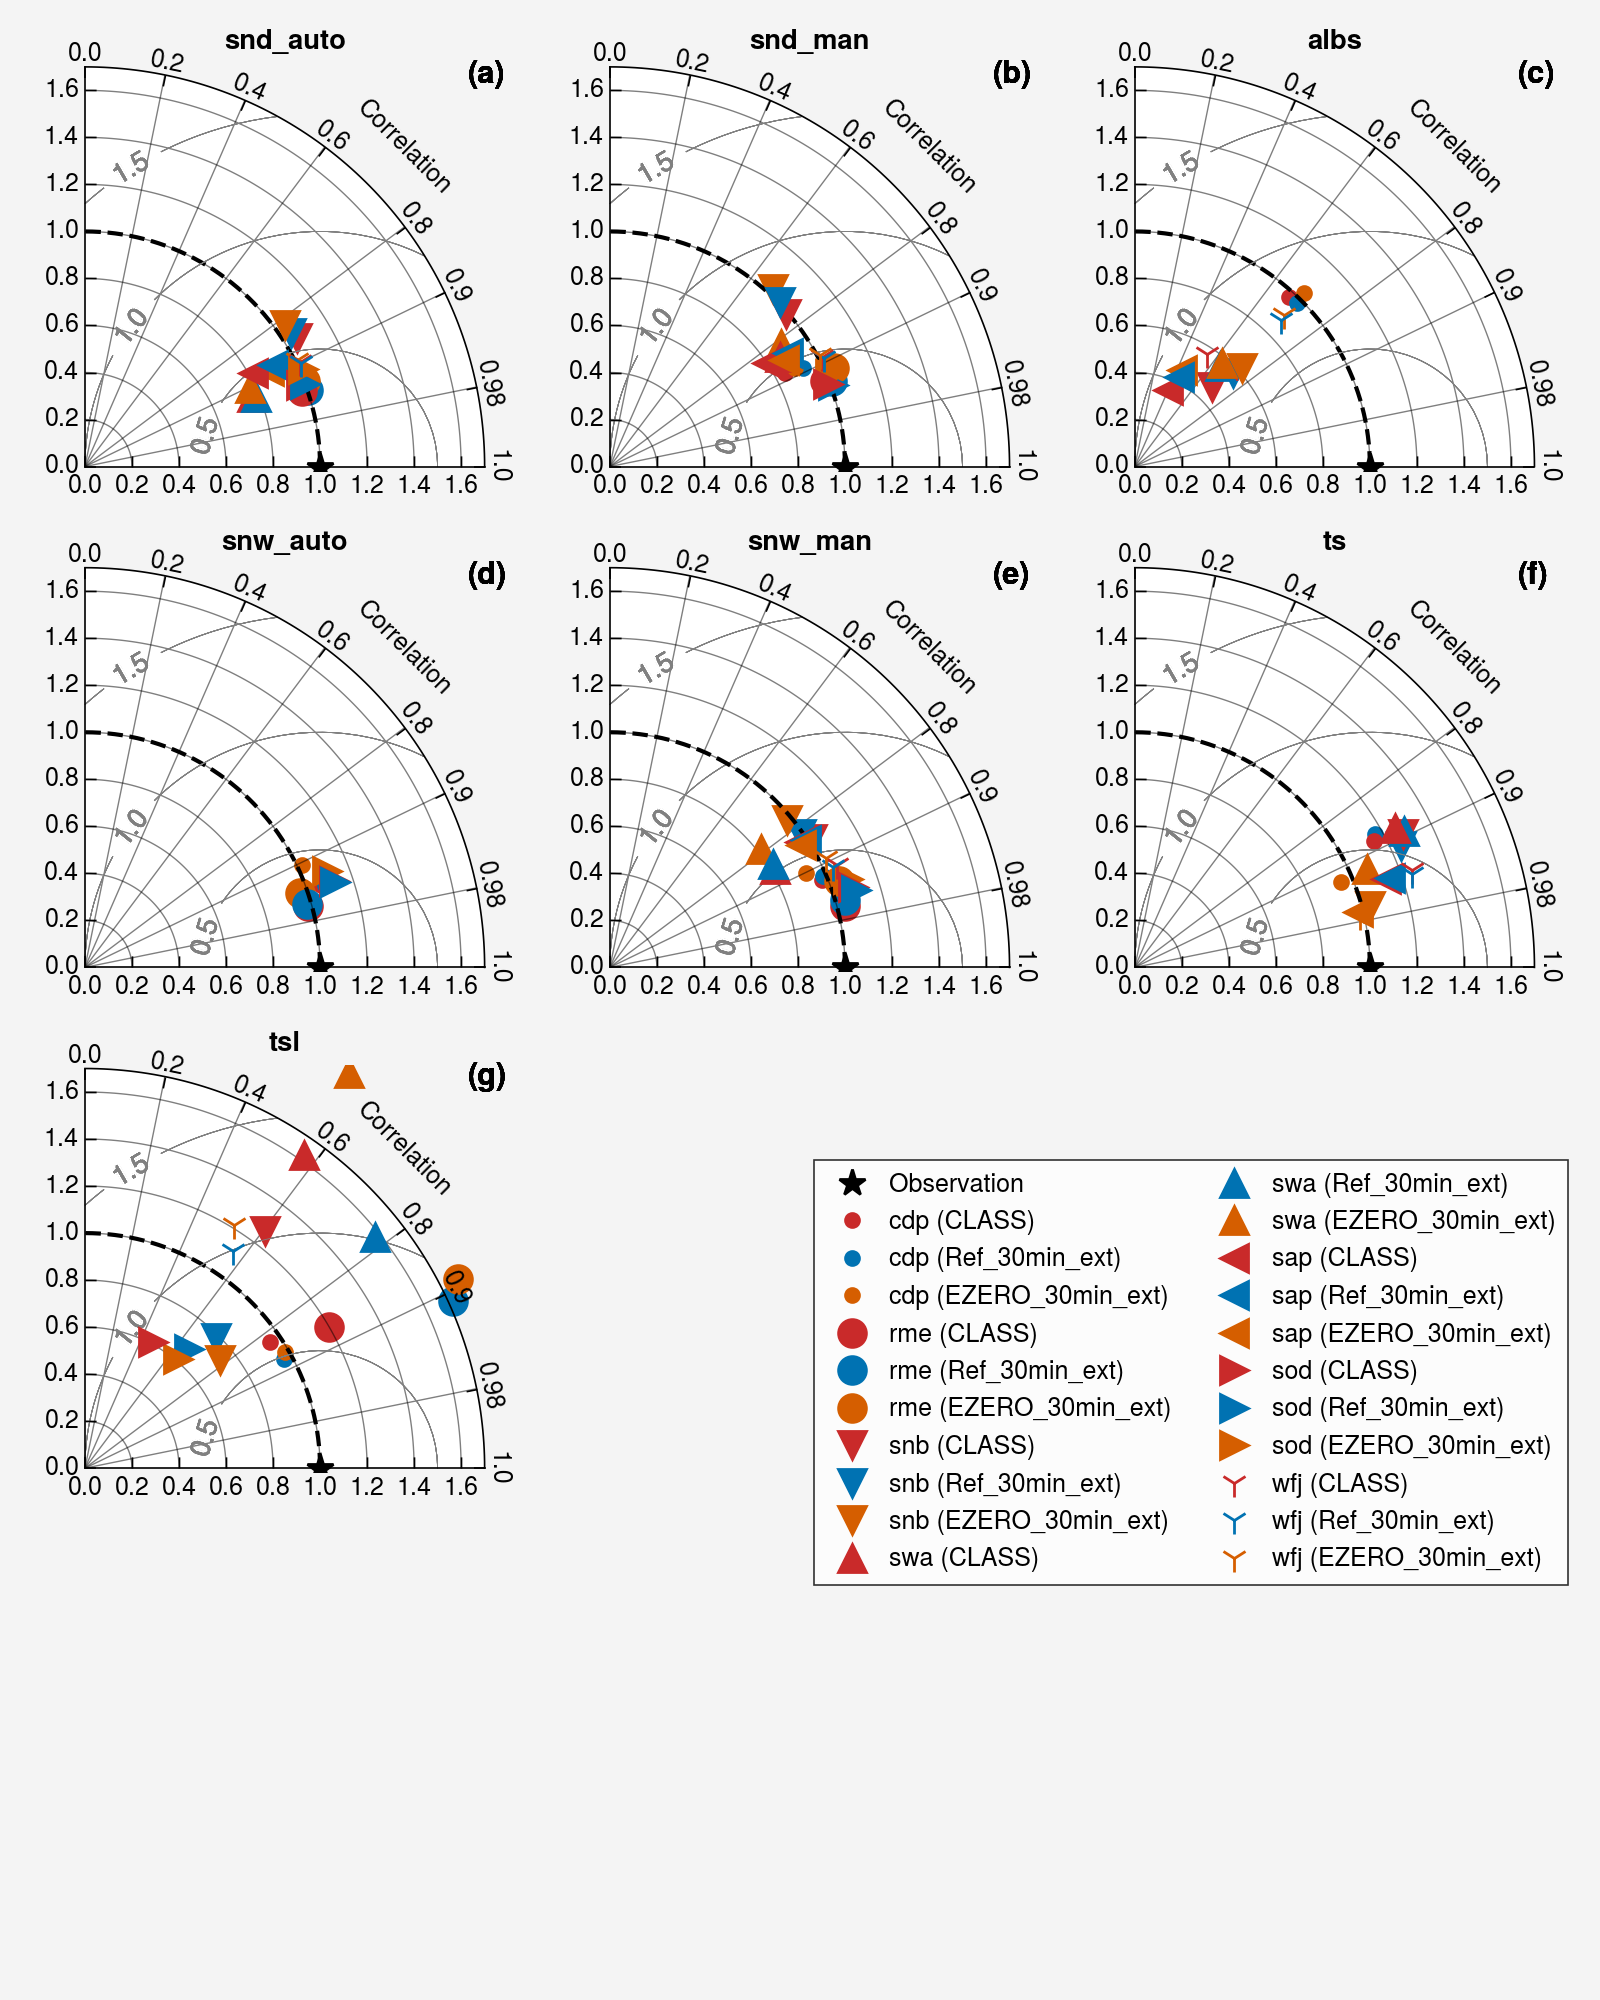

In [271]:
# n = 5
# marker = ['o']*n + ['P']*n + ['s']*n + ['^']*n + ['*']*n + ['x']*n + ['D']*n
# mec = ['C'+str(i) for i in range(n)]*6
# mfc = ['C'+str(i) for i in range(n)]*2 + [(0, 0, 0, 0)]*30

marker = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|' '_', 'P', 'X']
mec = ['red9', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
mfc = mec

# list_var = ['snd_auto', 'snd_man']
# list_var = ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl_10', 'tsl_20', 'tsl_50', 'tsn', 'SCD']
# list_var = ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts']
list_var = ['snd_auto', 'snd_man', 'albs', 'snw_auto', 'snw_man', 'ts', 'tsl']
rects = [431, 432, 433, 434, 435, 436, 437]
abc = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
srange = [(0, 1.7)]*len(rects)

# fig = PLT.figure(figsize=(8,10))
fig = PLT.figure(figsize=(8,10))

for i, var in enumerate(list_var):    
    dia = TaylorDiagram(1, fig=fig, rect=rects[i], label='Observation', srange=srange[i], extend=False) 
    
    for j, site in enumerate(SnowMIP_sites):
        dia.add_sample(df_metrics_list[j].loc[(var, 'CLASS'), 'stdd']/df_metrics_list[j].loc[(var, 'Obs'), 'stdd'], 
                       df_metrics_list[j].loc[(var, 'CLASS'), 'r'], marker=marker[j], ms=10, ls='',
                       mfc='red9', mec='red9', label=site.name + ':CLASS', zorder=j)

        for k, exp in enumerate(exps):
            dia.add_sample(df_metrics_list[j].loc[(var, exp), 'stdd']/df_metrics_list[j].loc[(var, 'Obs'), 'stdd'], 
                           df_metrics_list[j].loc[(var, exp), 'r'], marker=marker[j], ms=10, ls='', 
                           label=site.name + ':'+exp, zorder=j, mec='C'+str(k), mfc='C'+str(k))
    
            
        dia._ax.set_title(list_var[i], fontweight="bold")
        dia._ax.text(0.95, 0.95, abc[i], size=11, weight='bold', transform=dia._ax.transAxes)
        
        # Add RMS contours, and label them
        contours = dia.add_contours(levels=3, colors='0.5', linewidths=0.3)  # 5 levels in grey
        PLT.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
        # Grid
        dia._ax.grid(lw=0.5, alpha=0.5)
        if i in [7]: dia._ax.axis["left"].label.set_text("Normalized Standard Deviation")


fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           # numpoints=1, bbox_to_anchor=(0.98, 0.47), ncol=2)
           numpoints=1, bbox_to_anchor=(0.98, 0.42), ncol=2)

# fig.suptitle("Taylor diagram of spatial climatologies "+str(period.start)+"-"+period.stop, size='x-large')  # Figure title

fig.tight_layout()
# fig.savefig('img/taylor_cdp.jpg')
# for ext in ['jpg', 'png', 'pdf']:
#     fig.savefig('img/fig_taylor_diagram_Annual_PCC_'+str(period.start)+'-'+period.stop+'.'+ext, 

## Violin plots per sites

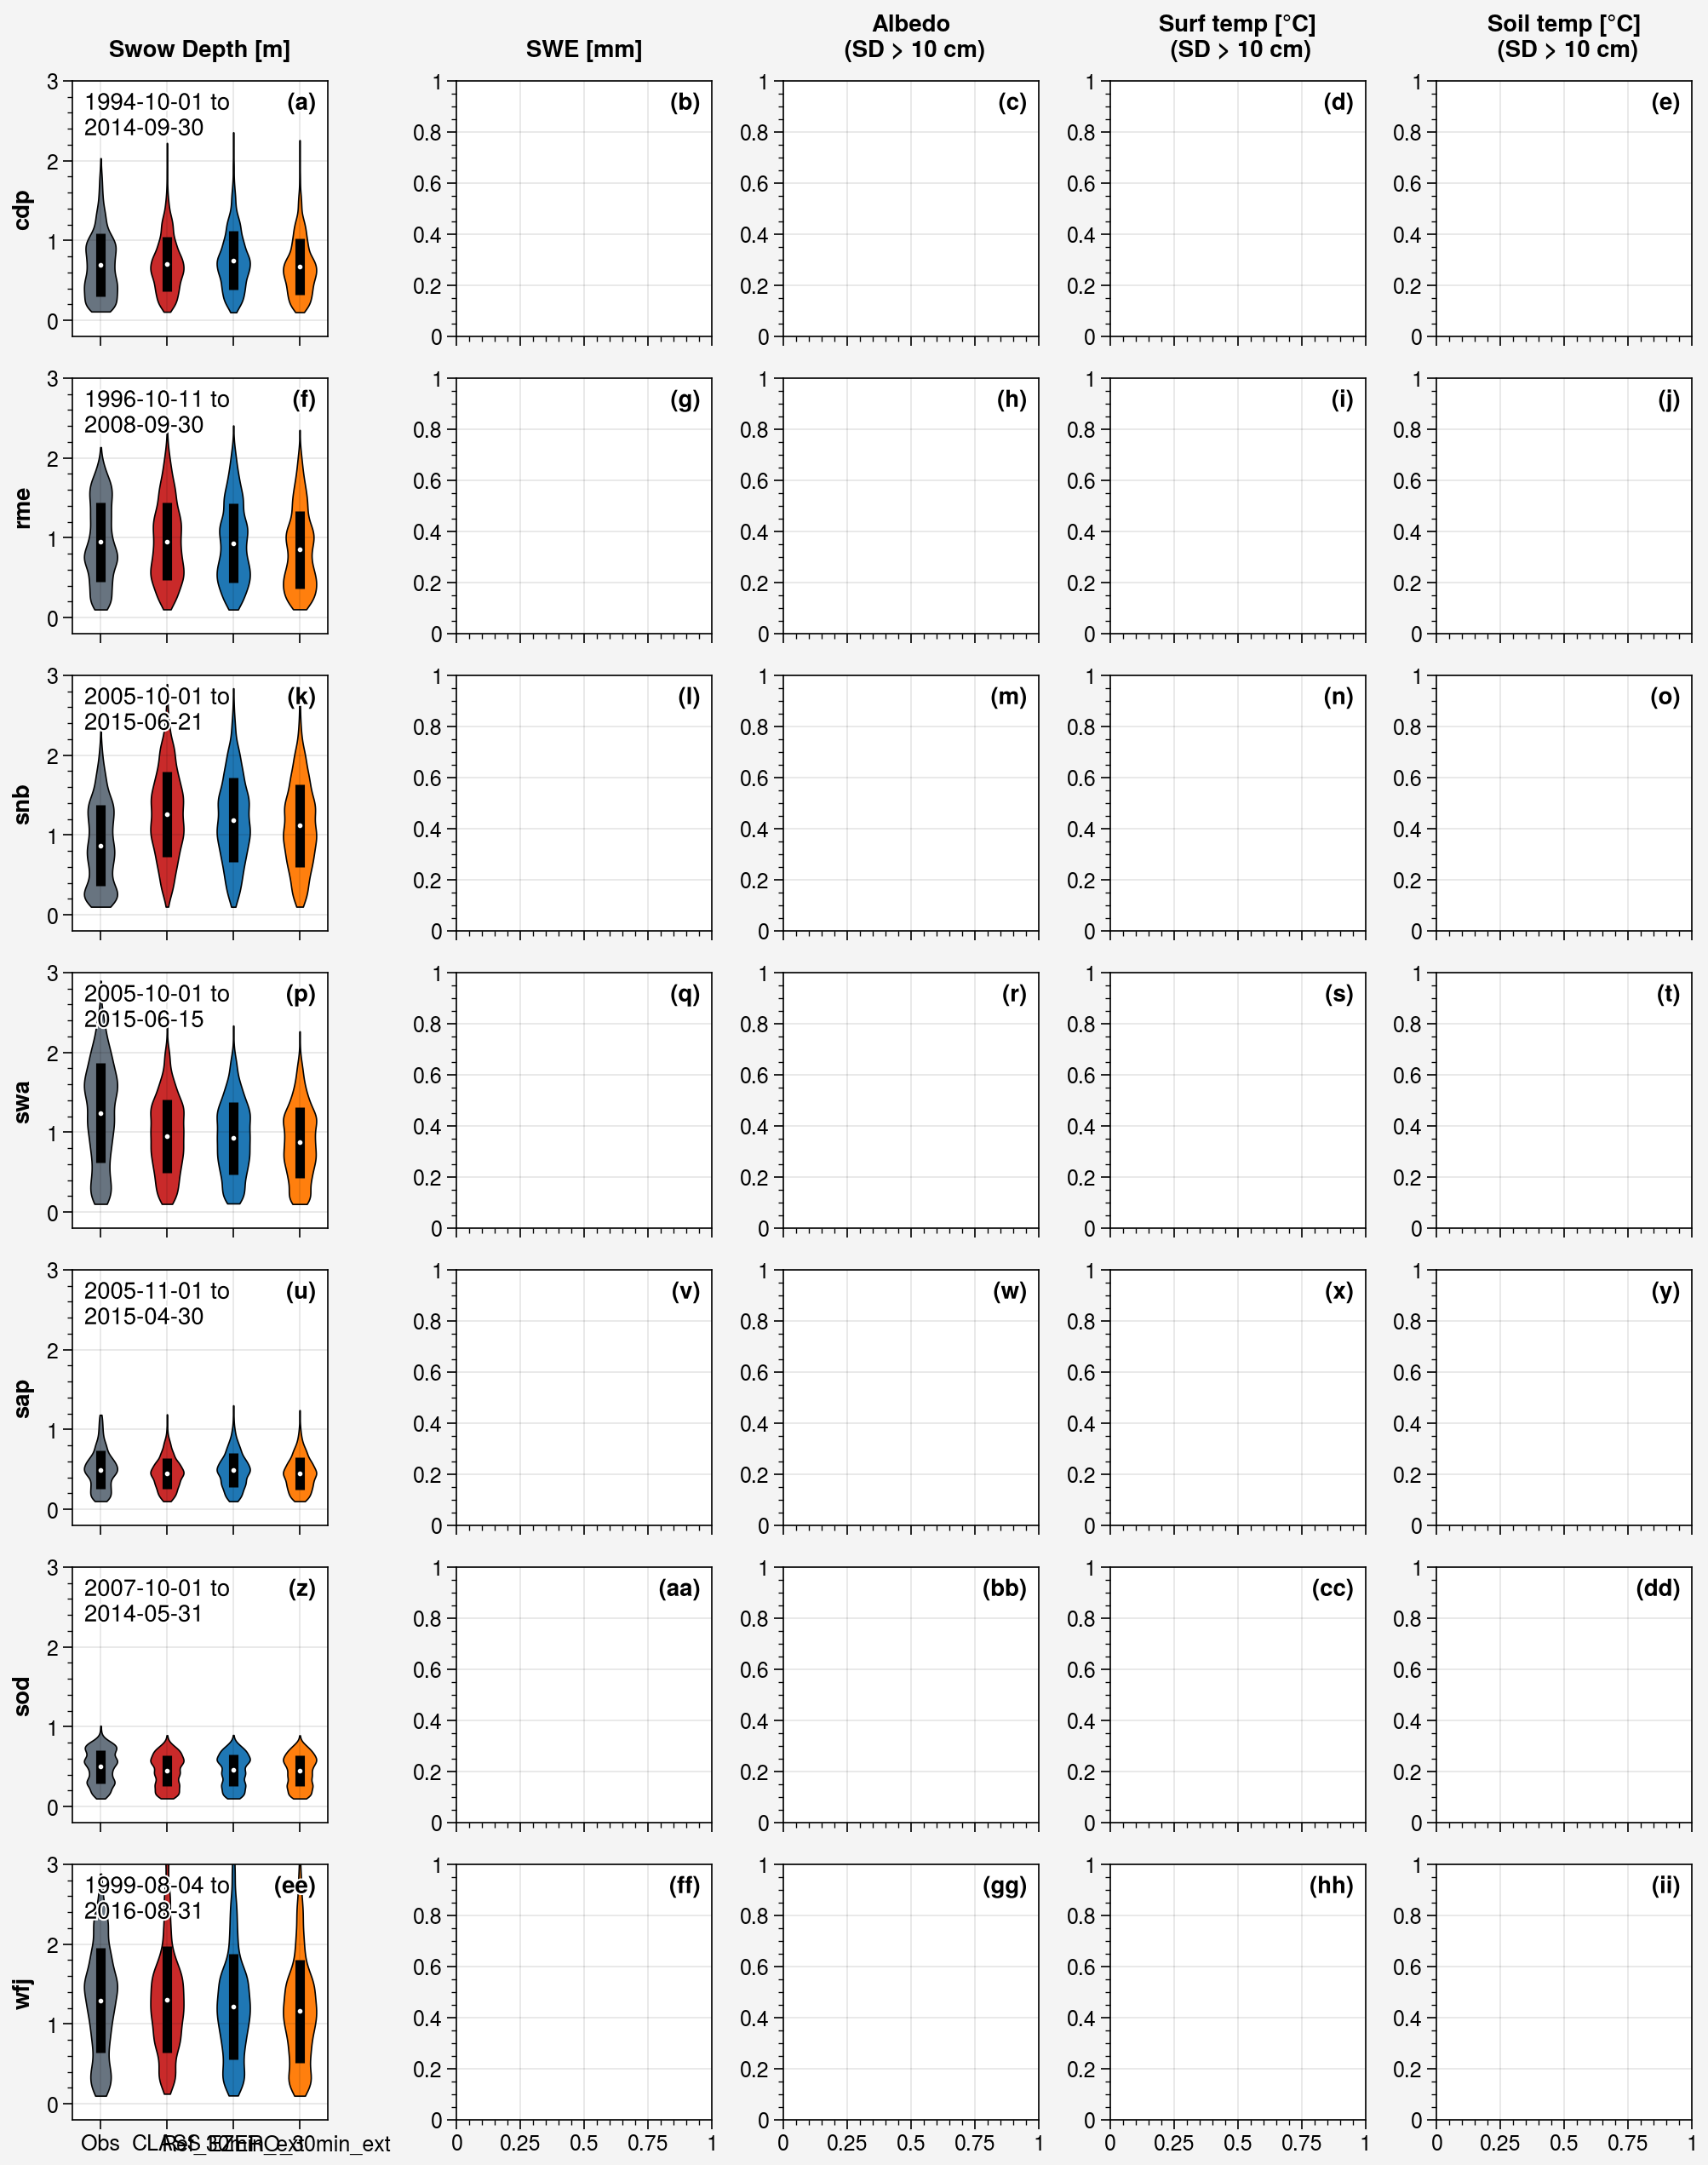

In [370]:
import warnings
warnings.filterwarnings("ignore")

color_obs = 'gray8'
colors = [np.array(pplt.colors.to_rgb(color_obs))*2, 'red9']+pplt.constructor.Cycle('default').by_key()['color']

fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites), refwidth=1.5, sharey=0)

# for i, site in enumerate([cdp]):
for i, site in enumerate(SnowMIP_sites):

    period = site.period_used

    # Snow depth
    ax = axs[i*5+0]
    mask_obs = ~ds_d_Obs_list[i].snd_auto.where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
    df_violon = ds_d_Obs_list[i].snd_auto.sel(time=period).where(mask_obs).to_dataframe()
    df_violon = df_violon.rename(columns={'snd_auto': 'Obs'})
    df_violon['CLASS'] = ds_d_Paul_list[i].snd.where(ds_d_Paul_list[i].snd > 0.1).sel(time=period).where(mask_obs)

    h_exps = []
    for j, exp in enumerate(exps):
        df_violon[exp] = ds_d_SnowMIP_list[j][i].snd.where(ds_d_SnowMIP_list[j][i].snd > 0.1).sel(time=period).where(mask_obs)
    
    ax.violin(df_violon, fillcolor=colors, means=True)
    ax.format(ylabel='', ylim=(-0.2,3),
              ultitle=str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
              str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[-1].values)[:10])    

    
    # # Snow Water Equivalent
    # ax = axs[i*5+1]

    # if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
    #     mask_obs = ~ds_d_Obs_list[i].snw_auto.sel(time=period).isnull()
        
    #     shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
    #                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
    #     obs = ds_d_Obs_list[i].snw_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    #     shadedata = np.concatenate((np.expand_dims(obs.values+25, axis=0), np.expand_dims(obs.values-25, axis=0),), axis=0)
    #     h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
    #     ax.format(ylabel='', ylim=(-40,1200),
    #               ultitle=str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
    #               str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[-1].values)[:10]) 

    # else:
    #     shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').quantile([0.1, 0.9])\
    #                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
    #     ax.format(ylabel='', ylim=(-40,1200), ultitle=period.start+' to\n'+ period.stop)


    # # Albedo (need to add a condition albsn > 0.4 because a few values are 0 in the model -> bug? (e.g., at Saporo)
    # # + low values are observed in the begining of the season (probably due to not full SCF coveraged)
    # ax = axs[i*5+2]
    # lim_alb = 0.4

    # if 'albs' in list(ds_d_Obs_list[i].keys()):
    #     mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > lim_alb).where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
        
    #     shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
    #                 .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
    #                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
    #                  .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
    #                     .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
    #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
    #                     .where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
    #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
    #     obs = ds_d_Obs_list[i].albs.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #             .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    #     h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
    #     ax.format(ylabel='', ylim=(0.4,0.9),
    #               lltitle=str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
    #               str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[-1].values)[:10]) 

    # else:
    #     shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
    #                 .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').quantile([0.1, 0.9])\
    #                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
    #                  .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
    #                     .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).groupby('time.dayofyear').mean()\
    #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
    #                     .where(ds_d_Paul_list[i].snd > 0.1).groupby('time.dayofyear').mean()\
    #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
    #     ax.format(ylabel='', ylim=(0.4,0.9), lltitle=period.start+' to\n'+ period.stop)
    
    
    # # Surface temperature
    # # Add condition on ts <= 0 on obs to avoid melting pachy areas to be counted
    # ax = axs[i*5+3]

    # if 'ts' in list(ds_d_Obs_list[i].keys()) and ds_d_Obs_list[i].ts.notnull().sum() != 0:
    #     mask_obs = ~ds_d_Obs_list[i].ts.sel(time=period).where(ds_d_Obs_list[i].ts <= 0)\
    #                 .where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
        
    #     shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
    #                 .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
    #                 .transpose('quantile', 'dayofyear')-273.15
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
    #                  .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                  .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
    #                     .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                     .roll(dayofyear=doy)-273.15, label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
    #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
    #     obs = ds_d_Obs_list[i].ts.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #             .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    #     h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
    #     ax.format(ylabel='', ylim=(-35,2),
    #               lltitle=str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
    #               str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[-1].values)[:10]) 

    # else:
    #     shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
    #                 .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
    #                 .transpose('quantile', 'dayofyear')-273.15
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
    #                  .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                  .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
    #                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                     .roll(dayofyear=doy)-273.15, label=exp, lw=1)
    #         h_exps.append(h)
        
    #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1)\
    #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
    #     ax.format(ylabel='', ylim=(-35,2), lltitle=period.start+' to\n'+ period.stop)

    
    # # Soil temperature
    # ax = axs[i*5+4]

    # if 'tsl' in list(ds_d_Obs_list[i].keys()):
        
    #     # Get the first soil layer from obs
    #     obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0)

    #     # For wfj (otherwise NaN so take the first model level)
    #     if obs_sdepth < 0.01: 
    #         model_sdepth = 0.05
    #     else:
    #         model_sdepth = obs_sdepth
    #     mask_obs = ~ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()

    #     # Interp model on the first soil layer obs
    #     if obs_sdepth < 0.01: 
    #         ds_d_interp = ds_d_SnowMIP_list[0][i]
    #     else:
    #         ds_d_interp = ds_d_SnowMIP_list[0][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
        
    #     shadedata = ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
    #                 .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
    #                 .transpose('quantile', 'dayofyear')-273.15
    #     h1 = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
    #                  .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                  .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):
    #         if obs_sdepth < 0.01: 
    #             ds_d_interp = ds_d_SnowMIP_list[j+1][i]
    #         else:
    #             ds_d_interp = ds_d_SnowMIP_list[j+1][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            
    #         h = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
    #                     .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                     .roll(dayofyear=doy)-273.15, label=exp, lw=1)
    #         h_exps.append(h)

    #     if obs_sdepth < 0.01: 
    #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
    #     else:
    #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
    #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
    #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

    #     obs = ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(mask_obs).groupby('time.dayofyear').mean()\
    #             .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    #     shadedata = np.concatenate((np.expand_dims(obs.values+0.4, axis=0), np.expand_dims(obs.values-0.4, axis=0),), axis=0)
    #     h_obs = ax.plot(obs, label='Obs', shadedata=shadedata, color=color_obs, lw=0.8, zorder=10)
    #     ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
    #     if obs_sdepth != model_sdepth: 
    #         ax.format(ylabel='', ylim=(-3, 5),
    #                   ultitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
    #                   str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
    #                      str(round(obs_sdepth*100))+' / '+str(round(model_sdepth*100))+' cm)') 
    #     else:
    #         ax.format(ylabel='', ylim=(-3, 5),
    #                   ultitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
    #                   str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
    #                      str(round(obs_sdepth*100))+' cm)')

    # else:
    #     model_sdepth = 0.05 # first level
        
    #     shadedata = ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
    #                 .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
    #                 .transpose('quantile', 'dayofyear')-273.15
    #     h1 = ax.plot(ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
    #                  .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                  .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    #     h_exps = []
    #     for j, exp in enumerate(exps[1:]):            
    #         h = ax.plot(ds_d_SnowMIP_list[j+1][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
    #                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                     .roll(dayofyear=doy)-273.15, label=exp, lw=1)
    #         h_exps.append(h)

    #     ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
    #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1)\
    #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
    #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

    #     ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
    #     ax.format(ylabel='', ylim=(-3, 5), lltitle=period.start+' to\n'+ period.stop+' ('+\
    #                  str(round(model_sdepth*100))+' cm)')
    
    
# for ax in axs:
#     ax.format(xlim=(40,350))
    
fig.format(abc='(a)', abcloc='ur', 
           collabels=['Swow Depth [m]', 'SWE [mm]', 'Albedo\n (SD > 10 cm)', 'Surf temp [°C]\n (SD > 10 cm)', 'Soil temp [°C]\n (SD > 10 cm)'],
           rowlabels=[site.name for site in SnowMIP_sites])
# fig.legend(h1+h_exps+h_paul+h_obs, loc='b', ncols=5)

# fig.save('img/tn1_ac.jpg')


In [275]:
df_test = ds_d_Obs_list[0].snd_auto.where(ds_d_Obs_list[0].snd_auto > 0.1).sel(time=cdp.period_used).to_dataframe()
df_test = df_test.rename(columns={'snd_auto': 'Obs'})
df_test['CLASS'] = ds_d_Paul_list[0].snd.where(ds_d_Paul_list[0].snd > 0.1).sel(time=cdp.period_used).values
df_test['CLASSIC'] = ds_d_SnowMIP_list[0][0].snd.where(ds_d_SnowMIP_list[0][0].snd > 0.1).sel(time=cdp.period_used).values
df_test

Obs  CLASS  CLASSIC
time                           
1994-10-01  NaN    NaN      NaN
1994-10-02  NaN    NaN      NaN
1994-10-03  NaN    NaN      NaN
1994-10-04  NaN    NaN      NaN
1994-10-05  NaN    NaN      NaN
...         ...    ...      ...
2014-09-26  NaN    NaN      NaN
2014-09-27  NaN    NaN      NaN
2014-09-28  NaN    NaN      NaN
2014-09-29  NaN    NaN      NaN
2014-09-30  NaN    NaN      NaN

[7305 rows x 3 columns]

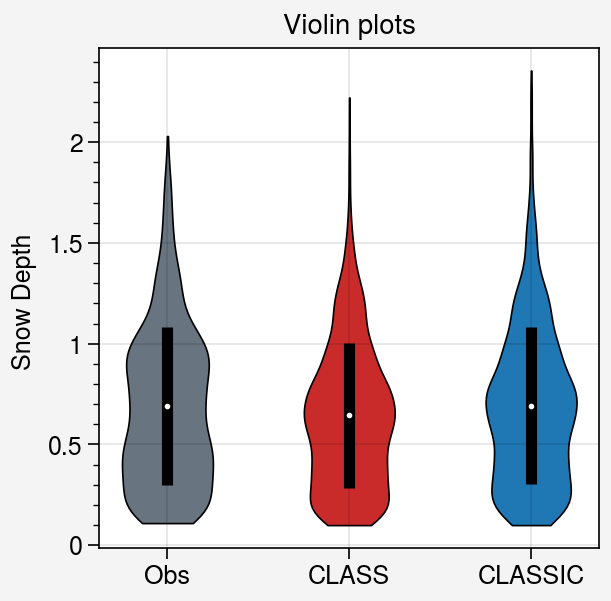

In [368]:
fig, axs = pplt.subplots()

# Violin plots
# axs[0].violin(df_test, fillcolor=[color_obs, 'red9', '#1f77b4ff'], means=True)
# colors = [np.array(pplt.colors.to_rgb(color))*2 for color in [color_obs, 'red9']+pplt.constructor.Cycle('default').by_key()['color']]
colors = [np.array(pplt.colors.to_rgb(color_obs))*2, 'red9']+pplt.constructor.Cycle('default').by_key()['color']
axs[0].violin(df_test, fillcolor=colors, means=True)
axs[0].format(title='Violin plots', ylabel='Snow depth ')

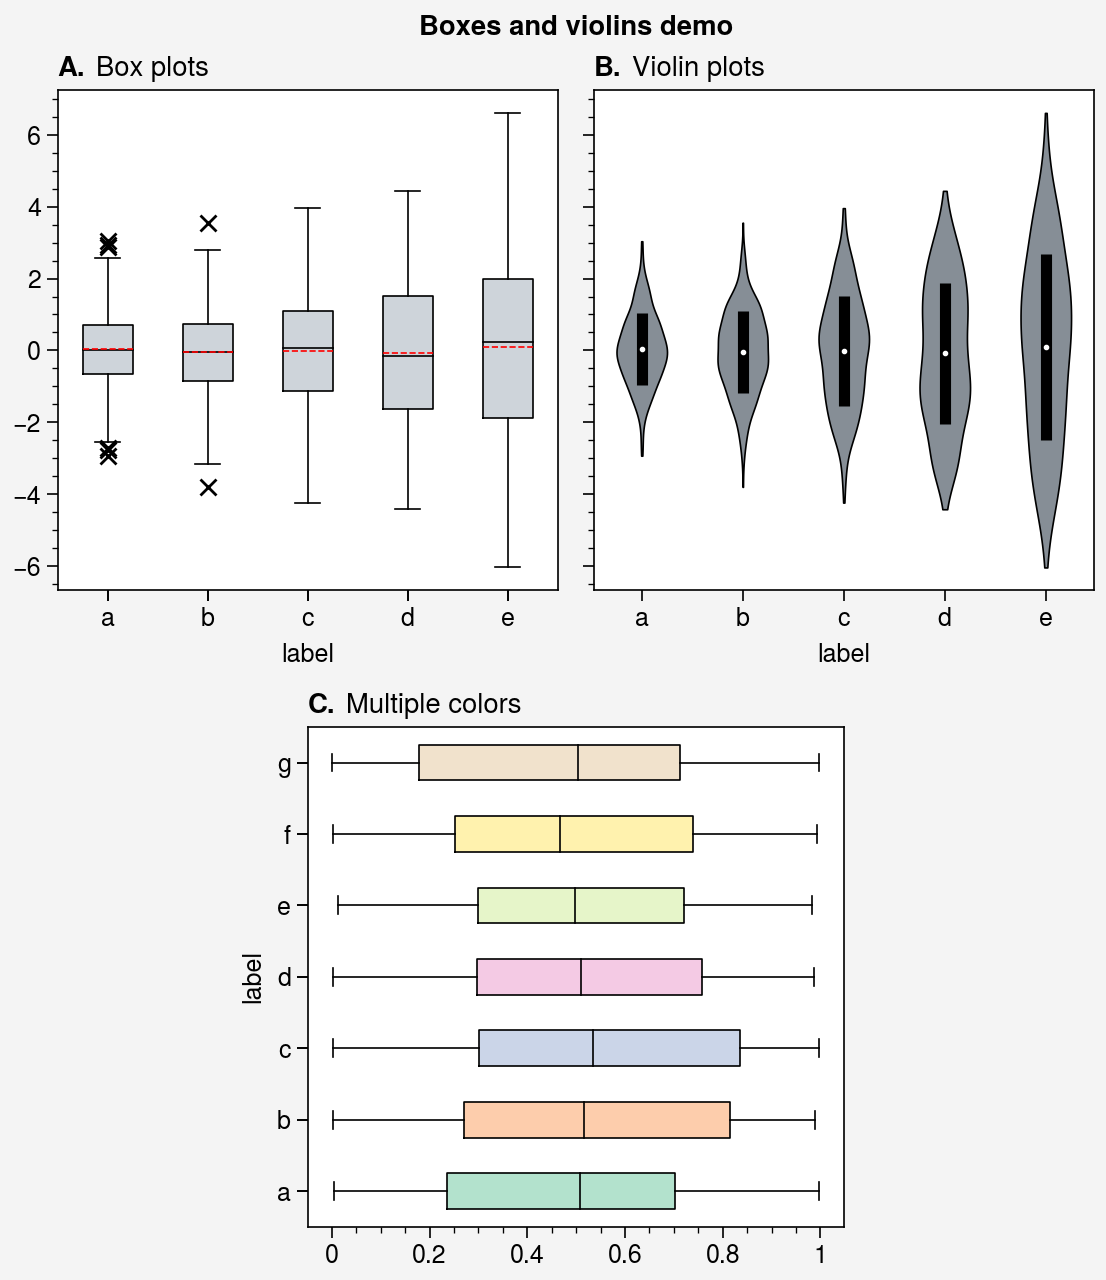

In [83]:
import proplot as pplt
import numpy as np
import pandas as pd

# Sample data
N = 500
state = np.random.RandomState(51423)
data1 = state.normal(size=(N, 5)) + 2 * (state.rand(N, 5) - 0.5) * np.arange(5)
data1 = pd.DataFrame(data1, columns=pd.Index(list('abcde'), name='label'))
data2 = state.rand(100, 7)
data2 = pd.DataFrame(data2, columns=pd.Index(list('abcdefg'), name='label'))

# Figure
fig, axs = pplt.subplots([[1, 1, 2, 2], [0, 3, 3, 0]], span=False)
axs.format(
    abc='A.', titleloc='l', grid=False,
    suptitle='Boxes and violins demo'
)

# Box plots
ax = axs[0]
obj1 = ax.box(data1, means=True, marker='x', meancolor='r', fillcolor='gray4')
ax.format(title='Box plots')

# Violin plots
ax = axs[1]
obj2 = ax.violin(data1, fillcolor='gray6', means=True, points=100)
ax.format(title='Violin plots')

# Boxes with different colors
ax = axs[2]
ax.boxh(data2, cycle='pastel2')
ax.format(title='Multiple colors', ymargin=0.15)

## Print metrics

In [273]:
df_metrics

mb        rmb        mab       rmab       rmse  \
snd_auto obs             0.0        0.0        0.0        0.0        0.0   
         ref        0.087628  12.674578    0.15941  23.057058   0.207805   
         paul       0.009846   1.424197   0.138836   20.08126    0.17702   
         scf_1      0.081005  11.716538   0.158198  22.881717   0.207117   
         grass      0.093378  13.506185   0.161964   23.42646   0.212195   
...                      ...        ...        ...        ...        ...   
SCD      grass     19.947368  14.221388  19.947368  14.221388  22.350085   
         ezero      8.947368   6.378987   9.578947   6.829268  12.573992   
         bg        21.157895  15.084428  21.157895  15.084428   23.84379   
         bg_scf_1 -24.157895 -17.223265  51.315789  36.585366  74.803251   
         soil      19.631579  13.996248  19.631579  13.996248   22.16327   

                       rrmse         r       stdd  
snd_auto obs             0.0       1.0   0.393558  
         ref       30.056886  0.886143   0.409659  
         paul      25.604197  0.893366    0.35925  
         scf_1     29.957389   0.88383   0.410592  
         grass     30.691898  0.884065   0.412035  
...                      ...       ...        ...  
SCD      grass     15.934395  0.881286  20.505658  
         ezero      8.964572  0.907751  20.169229  
         bg        16.999325   0.86052  20.780344  
         bg_scf_1  53.330648  0.156835  71.003999  
         soil      15.801205  0.874556  20.128259  

[99 rows x 8 columns]

In [372]:
column_indexes_print = ['mb', 'rmse', 'r', 'stdd']

row_indexes_print = [['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl_10', 'tsl_20', 'tsn', 'SCD'], 
                    ['obs', 'ref', 'paul', 'scf_1', 'ezero', 'grass', 'soil', 'bg', 'bg_scf_1']]

rows = pd.MultiIndex.from_product(row_indexes)
rows_print = pd.MultiIndex.from_product(row_indexes_print)

df_metrics_print = pd.DataFrame(index=rows_print, columns=column_indexes_print)
df_metrics_print.head()

mb rmse    r stdd
snd_auto obs    NaN  NaN  NaN  NaN
         ref    NaN  NaN  NaN  NaN
         paul   NaN  NaN  NaN  NaN
         scf_1  NaN  NaN  NaN  NaN
         ezero  NaN  NaN  NaN  NaN

In [373]:
for metric in column_indexes_print:
    for var in row_indexes_print[0]:
        for exp in row_indexes_print[1]:
            
            if var in ['snd_auto', 'snd_man']:
                if metric in ['mb', 'rmse']:
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} cm'.format(df_metrics.loc[(var, exp), metric]*100)+ \
                    ' ({:.0f}'.format(df_metrics.loc[(var, exp), 'r'+metric])+'%)'
                elif metric == 'r':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])
                elif metric == 'stdd':
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} cm'.format(df_metrics.loc[(var, exp), metric]*100)
                    
            elif var in ['snw_auto', 'snw_man']:
                if metric in ['mb', 'rmse']:
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} mm'.format(df_metrics.loc[(var, exp), metric])+ \
                    ' ({:.0f}'.format(df_metrics.loc[(var, exp), 'r'+metric])+'%)'
                elif metric == 'r':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])
                elif metric == 'stdd':
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} mm'.format(df_metrics.loc[(var, exp), metric])

            elif var in ['albs']:
                if metric in ['mb', 'rmse']:
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])+ \
                    ' ({:.0f}'.format(df_metrics.loc[(var, exp), 'r'+metric])+'%)'
                elif metric == 'r':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])
                elif metric == 'stdd':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])

            elif var in ['ts', 'tsl_10', 'tsl_20', 'tsl_50', 'tsn']:
                if metric in ['mb', 'rmse']:
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} °C'.format(df_metrics.loc[(var, exp), metric])+ \
                    ' ({:.0f}'.format(df_metrics.loc[(var, exp), 'r'+metric])+'%)'
                elif metric == 'r':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])
                elif metric == 'stdd':
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} °C'.format(df_metrics.loc[(var, exp), metric])

            elif var in ['SCD']:
                if metric in ['mb', 'rmse']:
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} d'.format(df_metrics.loc[(var, exp), metric])+ \
                    ' ({:.0f}'.format(df_metrics.loc[(var, exp), 'r'+metric])+'%)'
                elif metric == 'r':
                    df_metrics_print.loc[(var, exp), metric] = '{:.2f}'.format(df_metrics.loc[(var, exp), metric])
                elif metric == 'stdd':
                    df_metrics_print.loc[(var, exp), metric] = '{:.1f} d'.format(df_metrics.loc[(var, exp), metric])

df_metrics_print.loc['SCD']

mb          rmse     r    stdd
obs         0.0 d (0%)    0.0 d (0%)  1.00  19.6 d
ref       18.4 d (13%)  21.3 d (15%)  0.84  16.7 d
paul      18.5 d (13%)  22.3 d (16%)  0.77  15.8 d
scf_1     18.5 d (13%)  21.6 d (15%)  0.82  17.0 d
ezero       8.9 d (6%)  13.5 d (10%)  0.85  17.2 d
grass     19.5 d (14%)  22.2 d (16%)  0.84  16.7 d
soil      19.1 d (14%)  22.1 d (16%)  0.83  16.7 d
bg        21.2 d (15%)  24.3 d (17%)  0.79  17.3 d
bg_scf_1  19.8 d (14%)  23.0 d (17%)  0.81  17.2 d

In [379]:
df_metrics_print_table = df_metrics_print.rename(columns={'mb': 'MB', 'rmse': 'RMSE', 'stdd': 'STD'}, 
                       index={'obs': 'Obs', 'ref': 'Ref', 'paul': 'SnowMIP', 'scf_1': 'SCF_1', 'ezero': 'EZERO', 
                              'grass': 'Grass C3', 'soil': 'Soil LJ19', 'bg': 'Bare ground', 'bg_scf_1': 'Bare ground (SCF_1)'})


In [390]:
df_metrics_print_table.head(36*3).tail(36)

MB           RMSE     r     STD
tsl_10 Obs                     0.0 °C (0%)    0.0 °C (0%)  1.00  0.6 °C
       Ref                  -0.3 °C (-45%)   0.4 °C (70%)  0.88  0.7 °C
       SnowMIP              -0.1 °C (-22%)   0.4 °C (65%)  0.84  0.7 °C
       SCF_1                -0.2 °C (-41%)   0.4 °C (72%)  0.85  0.7 °C
       EZERO                -0.2 °C (-36%)   0.4 °C (64%)  0.88  0.7 °C
       Grass C3             -0.3 °C (-50%)   0.4 °C (72%)  0.87  0.6 °C
       Soil LJ19            -0.3 °C (-43%)   0.4 °C (68%)  0.88  0.7 °C
       Bare ground          -0.2 °C (-39%)   0.4 °C (70%)  0.87  0.8 °C
       Bare ground (SCF_1)  -0.2 °C (-36%)   0.4 °C (75%)  0.82  0.7 °C
tsl_20 Obs                     0.0 °C (0%)    0.0 °C (0%)  1.00  0.8 °C
       Ref                  -0.2 °C (-22%)   0.4 °C (52%)  0.90  0.9 °C
       SnowMIP                0.1 °C (11%)   0.4 °C (54%)  0.87  0.9 °C
       SCF_1                -0.1 °C (-18%)   0.4 °C (55%)  0.88  0.9 °C
       EZERO                -0.1 °C (-17%)   0.4 °C (48%)  0.90  0.9 °C
       Grass C3             -0.2 °C (-28%)   0.4 °C (54%)  0.89  0.8 °C
       Soil LJ19            -0.2 °C (-19%)   0.4 °C (50%)  0.89  0.9 °C
       Bare ground          -0.1 °C (-15%)   0.4 °C (53%)  0.89  1.0 °C
       Bare ground (SCF_1)  -0.2 °C (-21%)   0.5 °C (59%)  0.86  1.0 °C
tsn    Obs                     0.0 °C (0%)    0.0 °C (0%)  1.00  1.4 °C
       Ref                    0.7 °C (61%)  1.2 °C (106%)  0.77  0.9 °C
       SnowMIP               nan °C (nan%)  nan °C (nan%)   nan  nan °C
       SCF_1                 nan °C (nan%)  nan °C (nan%)   nan  nan °C
       EZERO                  0.8 °C (71%)  1.3 °C (119%)  0.71  0.8 °C
       Grass C3              nan °C (nan%)  nan °C (nan%)   nan  nan °C
       Soil LJ19             nan °C (nan%)  nan °C (nan%)   nan  nan °C
       Bare ground           nan °C (nan%)  nan °C (nan%)   nan  nan °C
       Bare ground (SCF_1)   nan °C (nan%)  nan °C (nan%)   nan  nan °C
SCD    Obs                      0.0 d (0%)     0.0 d (0%)  1.00  19.6 d
       Ref                    18.4 d (13%)   21.3 d (15%)  0.84  16.7 d
       SnowMIP                18.5 d (13%)   22.3 d (16%)  0.77  15.8 d
       SCF_1                  18.5 d (13%)   21.6 d (15%)  0.82  17.0 d
       EZERO                    8.9 d (6%)   13.5 d (10%)  0.85  17.2 d
       Grass C3               19.5 d (14%)   22.2 d (16%)  0.84  16.7 d
       Soil LJ19              19.1 d (14%)   22.1 d (16%)  0.83  16.7 d
       Bare ground            21.2 d (15%)   24.3 d (17%)  0.79  17.3 d
       Bare ground (SCF_1)    19.8 d (14%)   23.0 d (17%)  0.81  17.2 d

In [382]:
df_metrics_print_table.loc['snd_auto']

MB           RMSE     r      STD
Obs                    0.0 cm (0%)    0.0 cm (0%)  1.00  39.4 cm
Ref                   8.8 cm (13%)  20.8 cm (30%)  0.89  41.0 cm
SnowMIP                1.0 cm (1%)  17.7 cm (26%)  0.89  35.9 cm
SCF_1                 8.1 cm (12%)  20.7 cm (30%)  0.88  41.1 cm
EZERO                -2.0 cm (-3%)  17.7 cm (26%)  0.90  38.2 cm
Grass C3              9.3 cm (14%)  21.2 cm (31%)  0.88  41.2 cm
Soil LJ19             9.2 cm (13%)  20.9 cm (30%)  0.89  41.0 cm
Bare ground           8.0 cm (12%)  20.5 cm (30%)  0.89  40.7 cm
Bare ground (SCF_1)   8.2 cm (12%)  22.2 cm (32%)  0.86  40.9 cm

In [ ]:
df_metrics_print

rename 

column_indexes_print = ['obs', 'Ref', 'SnowMIP', 'SCF_1', 'EZERO', 'Grass C3', 'Soil LJ19', 'Bare ground', 'Bare ground (SCF_1)']

row_indexes_print = [['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl_10', 'tsl_20', 'tsl_50', 'tsn', 'SCD'], 
               ['MB', 'RMSE', 'r', 'STD']]